In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp
import gc

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

hdc = Hdc(10_000, xp)

xp = numpy


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs


((10000, 7), (2000, 7))


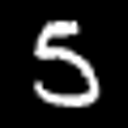
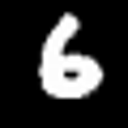
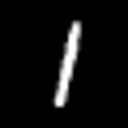
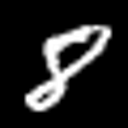
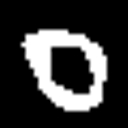
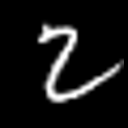
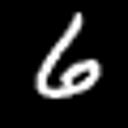
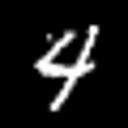
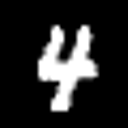
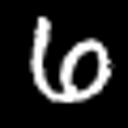
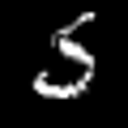
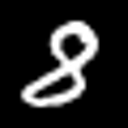
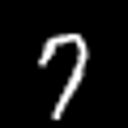
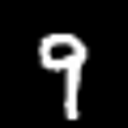
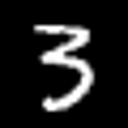
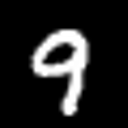

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Types

In [6]:
SeqLatentVecMeta = namedtuple('SeqLatentVecMeta', 
                              ['engram_id',
                               'seq_reading', 
                               'seq',
                               'seq_lv_ind',
                               'seq_lv_orig',
                               'seq_lv_upd',
                               #'w_vec',
                               'ones_count',
                               'history', # list of SeqLatentVecHistoryItem
                               'nu',
                               'cos_sim_thres',
                               'neg_matches_count',
                               'pos_matches_count'],
                              defaults=[0.1, COS_SIM_45, 0, 0])
SeqLatentVecHistoryItem = namedtuple('SeqLatentVecHistoryItem', ['image_id', 'cos_sim', 'is_correct_match'])
Engram = namedtuple('Engram', ['engram_id', 'image_id', 'value', 'seq_lv_inds', 'si_ind_dict'])
Matchee = namedtuple('Matchee', ['seqs', 'seq_lvs', 'seq_lvs_orig',  'seq_readings', 'si_ind_dict'])

## memory

In [7]:
SEQ_INGRESS_SUBLV_LEN = 150
SEQ_SEQ_SUBLV_LEN = 300
SEQ_SUBLV_LEN = SEQ_INGRESS_SUBLV_LEN + SEQ_SEQ_SUBLV_LEN
SEQ_SUBLVS_COUNT = 5
SEQ_LV_LEN = SEQ_SUBLV_LEN * SEQ_SUBLVS_COUNT
SEQ_LVS = HdvArray(SEQ_LV_LEN * 2, xp, dtype='f')
SEQ_LV_IND_TO_META = {} # key - index in SEQ_LVS, value - SeqLatentVecMeta
ENGRAMS = {} # key - engram id, value - engram instance
ENGRAM_ID_SOURCE = itertools.count(1)

In [8]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory():
    SEQ_LVS.clear()
    SEQ_LV_IND_TO_META.clear()
    ENGRAMS.clear()
    gc_memory()

## lambdas

In [9]:
expand_normal_vec = lambda j: (j.real, j.imag)
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, reading: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), reading))
get_normal_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: expand_normal_vec(si_ind_dict[si_ind].normal_vec), sequence)))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id, df_images: Image.open(io.BytesIO(df_images.loc[image_id]['png']))

## render_image

In [10]:
def render_image(image_id, df_images, image_sz=(600, 600)):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    inner_si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    inner_sequences = pickle.loads(df_image['inner_sequences'])
        
    for seq in inner_sequences:
        for si_ind_from, si_ind_to in zip(seq, seq[1:]):
            si_from = inner_si_ind_dict[si_ind_from]
            si_to = inner_si_ind_dict[si_ind_to]
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill='red')
            
            nl = 6 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline='red')
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_ind_from), anchor='mm', fill='red')

            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline='red')
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill='red')
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_ind_to), anchor='mm', fill='red')

    return image

## calc_seqs_latent_vector

In [11]:
def calc_seqs_latent_vector(sequences, si_ind_dict, seq_sublv_cache={}):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2), dtype='f')
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT, len(sequences)

    xy_prev_seq_tail = np.zeros(2)
    
    for sequence_i, (sequence, sublv) in enumerate(zip(sequences, seq_lv)):
        ingress_sublv = sublv[:SEQ_INGRESS_SUBLV_LEN]
        seq_sublv = sublv[SEQ_INGRESS_SUBLV_LEN:]
        
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        
        # 1) Ingress component of sublv, for very first sequence (sublv) there is no ingress 
        if sequence_i > 0:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            ingress_vec_len = int(np.round(np.linalg.norm(ingress_vec), decimals=0))
    
            if ingress_vec_len > 0:
                assert ingress_vec_len <= ingress_sublv.shape[0], ingress_vec_len
                ingress_sublv[:ingress_vec_len] = ingress_vec / ingress_vec_len
    
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last

        # 2) Seq component of sublv. 
        # At first check in cache - chances are that we've already done computation of seq_sublv.
        # Key for cache is starting si_ind. The bid here is that we have no duplicate si_ind within figure, 
        # as such each sub_lv is uniquely identified by starting si_ind
        starting_si_ind = sequence[0]

        if starting_si_ind in seq_sublv_cache:
            seq_sublv[:] = seq_sublv_cache[starting_si_ind]
        else:
            vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
            vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
            vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
            vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
            norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
            
            assert len(sequence) == vec_sequence.shape[0]
            assert len(sequence) == vec_len_sequence.shape[0]
            assert len(sequence) == norm_vec_sequence.shape[0]
            
            seq_len = vec_len_sequence.sum()
    
            if seq_len > 0:
                assert seq_len <= seq_sublv.shape[0], seq_len
                
                i = 0
                i_from = 0
                i_to = 0
        
                for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
                    if vec_len > 0:
                        i += vec_len
                        i_to = min(int(i), seq_sublv.shape[0])
                        assert i_from >= 0, i_from
                        assert i_to >= i_from, (i_to, i_from)
                        assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                        i_to2 = i_to
                        
                        if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                            i_to2 = seq_sublv.shape[0]
                
                        seq_sublv[i_from:i_to2] = norm_vec
                    
                    i_from = i_to
                
                    if i_to >= seq_sublv.shape[0]:
                        break
    
            seq_sublv_cache[starting_si_ind] = seq_sublv.copy() 
    
    return seq_lv.ravel()

In [12]:
def calc_seqs_latent_vector7(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2), dtype='f')
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    xy_prev_seq_tail = np.zeros(2)
    
    for sequence_i, (sequence, sublv) in enumerate(zip(sequences, seq_lv)):
        ingress_sublv = sublv[:SEQ_INGRESS_SUBLV_LEN]
        seq_sublv = sublv[SEQ_INGRESS_SUBLV_LEN:]
        
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()

        if seq_len == 0:
            continue
            
        assert seq_len <= seq_sublv.shape[0]

        # Ingress component of sublv
        if sequence_i > 0:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            ingress_vec_len = int(np.round(np.linalg.norm(ingress_vec), decimals=0))
    
            if ingress_vec_len > 0:
                assert ingress_vec_len <= ingress_sublv.shape[0], ingress_vec_len
                ingress_sublv[:ingress_vec_len] = ingress_vec / ingress_vec_len
    
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last

        # Seq component of sublv
        i = 0
        i_from = 0
        i_to = 0

        for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                seq_sublv[i_from:i_to2] = norm_vec
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
    
    seq_lv = seq_lv.ravel()
    seq_lv_len = np.linalg.norm(seq_lv)
    return seq_lv / seq_lv_len, seq_lv

In [13]:
def calc_seqs_latent_vector6(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()

        if seq_len == 0:
            continue
            
        assert seq_len <= seq_sublv.shape[0]
        
        i = 0
        i_from = 0
        i_to = 0
            
        for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                seq_sublv[i_from:i_to2] = norm_vec
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break

        # Put ingress vector (aka offset of this sequence) on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt # Works bad!, because of RNG.normal(-5, 0.1, 100) syndrom (<- such two random vectors will have cos sim near 1)

    seq_lv = seq_lv.ravel()
    seq_lv_len = np.linalg.norm(seq_lv)
    return seq_lv / seq_lv_len, seq_lv

In [14]:
def calc_seqs_latent_vector5(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()

        if seq_len == 0:
            continue
            
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        k = seq_sublv.shape[0] / seq_len # coeff to make sequence occupy whole sublv (stretch / shrink)
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i * k), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        # Put offset of this sequence on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences and the same time it would'nt overflow squared diffs
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt
    
    return seq_lv.ravel()

In [15]:
def calc_seqs_latent_vector4(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        if i_from < seq_sublv.shape[0] and i_from > 0:
            seq_sublv[i_from:] = 0
    
        # Put offset of this sequence on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences and the same time it would'nt overflow squared diffs
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt
    
    return seq_lv.ravel()

In [16]:
def calc_seqs_latent_vector3(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT

    pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence -= xy_sequence0
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        if i_from < seq_sublv.shape[0] and i_from > 0:
            seq_sublv[i_from:] = seq_sublv[i_from-1]
    
        # Put offset of this sequence on tip of latent vector. This way we would be able to 
        # account for differences in locations of sequences
        seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
        seq_sublv[0] = xy_sequence0 - pivot_pt
    
    return seq_lv.ravel()

In [17]:
def calc_seqs_latent_vector2(sequences, si_ind_dict):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT
    
    initial_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])
    
    for sequence, seq_sublv in zip(sequences, seq_lv):
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence -= initial_pt
        vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                         zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        seq_len = vec_len_sequence.sum()
        assert seq_len <= seq_sublv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
        
        i = 0
        i_from = 0
        i_to = 0
        pt = xy_sequence[0]
            
        for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
            if vec_len > 0:
                i += vec_len
                i_to = min(int(i), seq_sublv.shape[0])
                assert i_from >= 0, i_from
                assert i_to >= i_from, (i_to, i_from)
                assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                i_to2 = i_to
                
                if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                    i_to2 = seq_sublv.shape[0]
        
                pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
                seq_sublv[i_from:i_to2] = pts
                pt = pts[-1]
            
            i_from = i_to
        
            if i_to >= seq_sublv.shape[0]:
                break
        
        if i_from < seq_sublv.shape[0] and i_from > 0:
            seq_sublv[i_from:] = seq_sublv[i_from-1]
    
    return seq_lv.ravel()

## calc_seq_latent_vector

In [18]:
def calc_seq_latent_vector4(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence[vec_len_sequence <= 10].sum() # consider only intraseq 
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    pt = np.array([0, 0])
        
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 10:
            # interseq jump
            pt = pt + k * norm_vec * vec_len
            continue
        
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            i_to2 = i_to
            
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                i_to2 = seq_lv.shape[0]

            pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T # path interpolation
            seq_lv[i_from:i_to2,0:2] = pts
            seq_lv[i_from:i_to2,2] = 1 # TODO: get rid of
            pt = pts[-1]
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            # assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))), (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [19]:
def calc_seq_latent_vector3(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    pt = np.array([0, 0])
        
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            i_to2 = i_to
            
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                i_to2 = seq_lv.shape[0]

            pts = pt + (np.arange(1, i_to2 - i_from + 1) * norm_vec[np.newaxis,:].T).T
            seq_lv[i_from:i_to2,0:2] = pts
            seq_lv[i_from:i_to2,2] = -1 if is_interseq_jump else +1
            pt = pts[-1]
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [20]:
def calc_seq_latent_vector2(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    
    i = 0
    i_from = 0
    i_to = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            norm_vec = np.hstack([norm_vec, -1 if is_interseq_jump else +1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                seq_lv[i_from:] = norm_vec
            else:
                seq_lv[i_from:i_to] = norm_vec
    
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            break
    
        i_from = i_to

    return seq_lv.ravel()

In [21]:
def calc_seq_latent_vector1(sequence, si_ind_dict):
    xy_sequence = get_xy_sequence(sequence, si_ind_dict)
    # vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
    #                                  zip(xy_sequence, np.vstack([xy_sequence[1:], xy_sequence[:1]])))))
    vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
                                     zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
    vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
    vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
    vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
    norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
    assert sequence.shape[0] == vec_sequence.shape[0]
    assert sequence.shape[0] == vec_len_sequence.shape[0]
    assert sequence.shape[0] == norm_vec_sequence.shape[0]

    seq_len = vec_len_sequence.sum()
    seq_lv = np.zeros((SEQ_LV_LEN, 3))
    assert seq_len <= seq_lv.shape[0] # TODO: weak point if e.g. there is only one but very long sequence, think about it
    k = seq_lv.shape[0] / seq_len
    si_ind_to_phase = {}
    
    i = 0
    i_from = 0
    i_to = 0
    
    for j, (si_ind, norm_vec, vec_len) in enumerate(zip(sequence, norm_vec_sequence, vec_len_sequence)):
        if vec_len > 0:
            i += vec_len
            i_to = min(int(i * k), seq_lv.shape[0])
            assert i_from >= 0, i_from
            assert i_to >= i_from, (i_to, i_from)
            assert i_to <= seq_lv.shape[0], (i_to, seq_lv.shape[0])
            is_interseq_jump = vec_len > 10
            norm_vec = np.hstack([norm_vec, -1 if is_interseq_jump else +1])
        
            if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                seq_lv[i_from:] = norm_vec
            else:
                seq_lv[i_from:i_to] = norm_vec
    
        si_ind_to_phase[si_ind] = i_from * 3
        
        if i_to >= seq_lv.shape[0]:
            # Sometimes we may get si_inds with equal (x, y). This is due to resolution issues from hires to lores
            # (i.e. (x2, y2) for such si actually differ). 
            assert ((si_ind == sequence[-1]) or (all(map(lambda l: l == 0, vec_len_sequence[j+1:])))) , (si_ind, sequence[-1])
            remaining_si_inds = sequence[j+1:]
            si_ind_to_phase.update(map(lambda si_ind: (si_ind, i_from * 3), remaining_si_inds))
            break
    
        i_from = i_to

    return seq_lv.ravel(), si_ind_to_phase

## create_engram

In [22]:
def create_engram(df_image, matchee=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    sequences = sequences[:SEQ_SUBLVS_COUNT] # TODO: cope somehow with more thatn SEQ_SUBLV_COUNT, e.g. generate several seq_lvs
    seq_readings = [tuple(zip(range(len(sequences)), (0,) * len(sequences)))] # default reading
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_sublv_cache = {}
    
    for seq_reading in seq_readings:
        sequences_reading = get_sequences_reading(sequences, seq_reading)
        seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict, seq_sublv_cache)

        ones_count = (seq_lv != 0).sum()
        # w_vec = np.zeros_like(seq_lv, dtype='f')
        # w_vec[seq_lv != 0] = 1
    
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv / np.linalg.norm(seq_lv))
        
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, 
                                       seq_reading=seq_reading, 
                                       seq=get_sequence(sequences_reading), 
                                       seq_lv_ind=seq_lv_ind,
                                       seq_lv_orig=seq_lv,
                                       seq_lv_upd=seq_lv,
                                       ones_count=ones_count,
                                       history={})
                                       #w_vec=w_vec)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=[seq_lv_ind], si_ind_dict=si_ind_dict)

In [23]:
def create_engram5(df_image, matchee=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])

    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT

    seq_lv_code = tuple(map(lambda seq_index: (seq_index, 0), seq_indices))
    sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
    seq_lv, seq_lv2 = calc_seqs_latent_vector(sequences_reading, si_ind_dict)

    seq_lv_ind = SEQ_LVS.lease()
    SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv)
    
    # assert SEQ_LVS2.lease() == seq_lv_ind
    # SEQ_LVS2.array_active[seq_lv_ind] = seq_lv2
        
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=get_sequence(sequences), seq_lv_ind=seq_lv_ind)
    SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=[seq_lv_ind], si_ind_dict=si_ind_dict)

In [24]:
def create_engram4(df_image, matchee=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    seq_lv_codes = []
    seq_lvs = []
    seq_lvs2 = []
    seqs = []

    if matchee is None:
        # Persist various readings of sequences
        if len(sequences) > SEQ_SUBLVS_COUNT:
            seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
            # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
        else:
            seq_indices = list(range(len(sequences)))
            
        assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))

        for seq_lv_code in seq_lv_codes:
            sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
            seq_lv, seq_lv2 = calc_seqs_latent_vector(sequences_reading, si_ind_dict)
            seq_lvs.append(seq_lv)
            seq_lvs2.append(seq_lv2)
            seqs.append(get_sequence(sequences_reading))
    else:
        seq_lv_codes = matchee.seq_lv_codes
        seq_lvs = matchee.seq_lvs
        seq_lvs2 = matchee.seq_lvs2
        seqs = matchee.seqs
    
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []
    
    for seq_lv_code, seq_lv, seq_lv2, seq in zip(seq_lv_codes, seq_lvs, seq_lvs2, seqs):
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv)
        
        # assert SEQ_LVS2.lease() == seq_lv_ind
        # SEQ_LVS2.array_active[seq_lv_ind] = seq_lv2
            
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=seq, seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [25]:
def create_engram3(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []

    # Persist various readings of sequences
    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    
    seq_lv_codes = []

    for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
        for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
            seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))

    # for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
    #     seq_lv_codes.append(tuple(zip(perm_seq_indices, (0,) * len(seq_indices))))
    
    # for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
    #     seq_lv_codes.append(list(zip(seq_indices, seq_orientation)))
    
    for seq_lv_code in seq_lv_codes:
        sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
        seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict)

        seq_lv_ind = SEQ_LVS_COS_SIM.lease()
        SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
        assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
        SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
        
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=0, seq_lv_code=seq_lv_code, seq=get_sequence(sequences_reading), seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [26]:
def create_engram2(df_image):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    sequence = get_sequence(sequences) # assemble default sequence
    engram_id = next(ENGRAM_ID_SOURCE)
    seq_lv_inds = []
    
    # Phasing (for sequences near to circular) + persisting
    for i, si_ind in enumerate(sequence):
        seq = np.roll(sequence, -i, axis=0)
        seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
        # seq_lv_ind = SEQ_LVS.lease()
        # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        
        seq_lv_ind = SEQ_LVS_COS_SIM.lease()
        SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
        # assert SEQ_LVS_CORR.lease() == seq_lv_ind
        # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
        assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
        SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
        
        seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=i, seq=seq, seq_lv_ind=seq_lv_ind)
        SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
        seq_lv_inds.append(seq_lv_ind)
        
    return Engram(engram_id=engram_id, image_id=int(int(df_image.name)), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

In [27]:
# def create_engram(df_image):
#     image_id = int(df_image.name)
#     si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
#     sequences = pickle.loads(df_image['inner_sequences'])
#     sequence = get_sequence(sequences) # assembly default sequence
#     engram_id = next(ENGRAM_ID_SOURCE)
#     seq_lv_inds = []
    
#     # Phasing (for sequences near to circular) + persisting
#     for i, si_ind in enumerate(sequence):
#         seq = np.roll(sequence, -i, axis=0)
#         seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
        
#         phase = si_ind_to_phase[si_ind]
#         phased_seq_lv = np.roll(seq_lv, -phase, axis=0)
#         # seq_lv_ind = SEQ_LVS.lease()
#         # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
        
#         seq_lv_ind = SEQ_LVS_COS_SIM.lease()
#         SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = phased_seq_lv
#         # assert SEQ_LVS_CORR.lease() == seq_lv_ind
#         # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
#         assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
#         SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([phased_seq_lv ** 2, np.full_like(phased_seq_lv, 1, dtype=phased_seq_lv.dtype)])
        
#         seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=phase, seq=phased_seq, seq_lv_ind=seq_lv_ind)
#         SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
#         seq_lv_inds.append(seq_lv_ind)
        
#     return Engram(engram_id=engram_id, image_id=int(image_id), value=df_image['value'], seq_lv_inds=seq_lv_inds, si_ind_dict=si_ind_dict)

## create_matchee

In [28]:
def create_matchee(df_image, seq_reading=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    seq_readings = []

    if seq_reading is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                seq_readings.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        seq_readings.append(seq_reading)

    seq_sublv_cache = {}
    seqs, seq_lvs = [], []
    
    for seq_reading in seq_readings:
        sequences_reading = get_sequences_reading(sequences, seq_reading)
        seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict, seq_sublv_cache)
        seqs.append(get_sequence(sequences_reading))
        seq_lvs.append(seq_lv)

    seq_lvs_norm = xp.array(seq_lvs)
    seq_lvs_norm = (seq_lvs_norm.T / xp.linalg.norm(seq_lvs_norm, axis=1)).T
    return Matchee(seqs=seqs, seq_lvs=seq_lvs_norm, seq_lvs_orig=seq_lvs, seq_readings=seq_readings, si_ind_dict=si_ind_dict)

In [29]:
def create_matchee3(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_corr=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)
    
    for seq_lv_code in matchee.seq_lv_codes:
        sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
        seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict)
        matchee.seqs.append(get_sequence(sequences_reading))
        # matchee.seq_lvs.append(seq_lv)
        matchee.seq_lvs_cos_sim.append(seq_lv)
        # matchee.seq_lvs_corr.append((seq_lv - seq_lv.mean()) / seq_lv.std())
        matchee.seq_lvs_diff_sq.append(np.hstack([np.full_like(seq_lv, 1, dtype=seq_lv.dtype), seq_lv ** 2]))

    # return matchee._replace(seq_lvs=np.array(matchee.seq_lvs))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_corr=np.array(matchee.seq_lvs_corr), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))
    return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

In [30]:
def create_matchee2(df_image, seq_lv_code=None):
    si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
    sequences = pickle.loads(df_image['inner_sequences'])
    # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    # matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_corr=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    MAX_SEQUENCES_COUNT = 5

    if len(sequences) > MAX_SEQUENCES_COUNT:
        seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= MAX_SEQUENCES_COUNT

    if seq_lv_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                matchee.seq_lv_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        matchee.seq_lv_codes.append(seq_lv_code)
    
    for seq_lv_code in matchee.seq_lv_codes:
        maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
        sequence = np.array(list(itertools.chain.from_iterable(maps)))
        # seq_lv, _ = calc_seq_latent_vector(sequence, si_ind_dict)
        seq_lv = calc_seq_latent_vector(sequence, si_ind_dict)
        matchee.seqs.append(sequence)
        # matchee.seq_lvs.append(seq_lv)
        matchee.seq_lvs_cos_sim.append(seq_lv)
        # matchee.seq_lvs_corr.append((seq_lv - seq_lv.mean()) / seq_lv.std())
        matchee.seq_lvs_diff_sq.append(np.hstack([np.full_like(seq_lv, 1, dtype=seq_lv.dtype), seq_lv ** 2]))

    # return matchee._replace(seq_lvs=np.array(matchee.seq_lvs))
    # return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_corr=np.array(matchee.seq_lvs_corr), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))
    return matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

## create_matchee_cached

In [194]:
MATCHEE_CACHE = {}

In [200]:
def create_matchee_cached(df_image, seq_reading=None):
    image_id = int(df_image.name)
    cache_key = (image_id, seq_reading)

    if not cache_key in MATCHEE_CACHE:
        MATCHEE_CACHE[cache_key] = create_matchee(df_image, seq_reading)

    return MATCHEE_CACHE[cache_key]    

## get_match_tab

In [31]:
def get_match_tab(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sims = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sims = np.flip(cos_sims)

    for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['cos_sim'].append(cos_sim)
        match_tab_columns['cos_sim_thres'].append(seq_lv_meta.cos_sim_thres)
        match_tab_columns['is_match'].append(cos_sim >= seq_lv_meta.cos_sim_thres)
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_seq_reading'].append(seq_lv_meta.seq_reading)
        match_tab_columns['engram_seq_lv_orig'].append(seq_lv_meta.seq_lv_orig)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['matchee_seq_reading'].append(matchee.seq_readings[j])
        match_tab_columns['matchee_seq_lv_orig'].append(matchee.seq_lvs_orig[j])

    return pd.DataFrame(match_tab_columns)

In [32]:
def get_match_tab6(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sims = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sims = np.flip(cos_sims)

    for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]

        w_vec = seq_lv_meta.w_vec
        engram_seq_lv_orig_w = seq_lv_meta.seq_lv_orig * w_vec
        # matchee_seq_lv_orig_w = matchee.seq_lvs_orig[j] * w_vec
        matchee_seq_lv_orig_w = matchee.seq_lvs_orig[j]
        cos_sim_flt = engram_seq_lv_orig_w @ matchee_seq_lv_orig_w / (np.linalg.norm(engram_seq_lv_orig_w) * np.linalg.norm(matchee_seq_lv_orig_w)) 
        
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sim)
        match_tab_columns['cos_sim_flt'].append(cos_sim_flt)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_seq_reading'].append(seq_lv_meta.seq_reading)
        match_tab_columns['matchee_seq_reading'].append(matchee.seq_readings[j])
        match_tab_columns['engram_seq_lv_orig'].append(seq_lv_meta.seq_lv_orig)
        match_tab_columns['matchee_seq_lv_orig'].append(matchee.seq_lvs_orig[j])

    res = pd.DataFrame(match_tab_columns)

    if len(res) > 0:
        res.sort_values(by=['cos_sim_flt'], ascending=False, inplace=True)

    return res

In [33]:
def get_match_tab5(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    # diff_mat = xp.zeros((SEQ_LVS.active_len, matchee.seq_lvs.shape[0]))

    # for seq_lv_ind, seq_lv in enumerate(matchee.seq_lvs): # this is too slow
    #     diffs = xp.sum(xp.absolute(SEQ_LVS.array_active - seq_lv), axis=1)
    #     diff_mat[:,seq_lv_ind] = diffs
    # diff_mat = xp.sum(xp.absolute(SEQ_LVS.array_active[:,np.newaxis,:] - matchee.seq_lvs), axis=-1) # this requires too much memory!!!
    diff_mat = xp.zeros((SEQ_LVS.active_len, matchee.seq_lvs.shape[0]))

    batch_size = SEQ_LVS.active_len if matchee.seq_lvs.shape[0] < 100 else 100
    batch_size = max(100, batch_size)
    
    for i in range(0, SEQ_LVS.active_len, batch_size):
        diff_submat = xp.sum(xp.absolute(SEQ_LVS.array_active[i:i+batch_size,np.newaxis,:] - matchee.seq_lvs), axis=-1)
        diff_mat[i:i+batch_size] = diff_submat
    
    top_mat_indices = xp.argsort(diff_mat, axis=None)[-inspect_depth:]
    diff_values = xp.take(diff_mat, top_mat_indices)

    for top_mat_index, diff_value in zip(top_mat_indices, diff_values):
        i = top_mat_index // diff_mat.shape[1]
        j = top_mat_index % diff_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        # match_tab_columns['cos_sim'].append(cos_sim_value)
        # match_tab_columns['diff'].append(diff)
        # match_tab_columns['diff2'].append(diff)
        match_tab_columns['diff3'].append(diff_value)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        # match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [34]:
def get_match_tab4(matchee, inspect_depth=100, sort_by='diff2'):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sim_values = np.flip(cos_sim_values)
    
    for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        diff = np.sum(np.absolute(SEQ_LVS.array_active[i] - matchee.seq_lvs[j]))
        diff2 = np.sum(np.absolute(SEQ_LVS2.array_active[i] - matchee.seq_lvs2[j]))
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sim_value)
        match_tab_columns['diff'].append(diff)
        match_tab_columns['diff2'].append(diff)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        # match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    df = pd.DataFrame(match_tab_columns)

    if len(df) > 0 and sort_by != 'cos_sim':
        df.sort_values(by=[sort_by], ascending=True, inplace=True)
        
    return df

In [35]:
def get_match_tab3(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sim_values = np.flip(cos_sim_values)
    
    for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sim_value)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [36]:
def get_match_tab2(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
    diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat
    top_mat_indices = np.argsort(diff_sq_mat, axis=None)[:inspect_depth] 
    
    for top_mat_index in top_mat_indices:
        i = top_mat_index // diff_sq_mat.shape[1]
        j = top_mat_index % diff_sq_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(-1)
        match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [37]:
MATCH_TAB_METHOD = 'cos_sim'

def get_match_tab1(matchee, method=None, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    dot_prod_mat = (SEQ_LVS_COS_SIM.array_active @ matchee.seq_lvs_cos_sim.T)
    cos_sim_mat = dot_prod_mat / (-2 * SEQ_LV_LEN)
    # corr_mat = (SEQ_LVS_CORR.array_active @ matchee.seq_lvs_corr.T) / (-SEQ_LVS_CORR.array_active.shape[1])
    diff_sq_mat = (SEQ_LVS_DIFF_SQ.array_active @ matchee.seq_lvs_diff_sq.T) - dot_prod_mat - dot_prod_mat
    
    mat = {
        'cos_sim': cos_sim_mat,
        # 'corr': corr_mat,
        'diff_sq': diff_sq_mat
    }[MATCH_TAB_METHOD if method is None else method]
    top_mat_indices = np.argsort(mat, axis=None)[:inspect_depth] 
    
    for top_mat_index in top_mat_indices:
        i = top_mat_index // mat.shape[1]
        j = top_mat_index % mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(-cos_sim_mat[i,j])
        # match_tab_columns['corr'].append(-corr_mat[i,j])
        match_tab_columns['diff_sq'].append(diff_sq_mat[i,j])  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

In [38]:
def get_match_tab2(matchee, compute_diff=False, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sims_mat = (SEQ_LVS.array_active @ matchee.seq_lvs.T) / SEQ_LV_LEN # TODO: division can be omitted actually
    top_cos_sim_indices = np.argsort(cos_sims_mat, axis=None)[-inspect_depth:] 
    
    for cos_sim_index in reversed(top_cos_sim_indices):
        i = cos_sim_index // cos_sims_mat.shape[1]
        j = cos_sim_index % cos_sims_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]

        if compute_diff:
            engram_seq_lv = SEQ_LVS.array_active[i]
            matchee_seq_lv = matchee.seq_lvs[j]
            diff = compute_seq_lvs_diff(engram_seq_lv, matchee_seq_lv)
        else:
            diff = -1
            
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['cos_sim'].append(cos_sims_mat[i,j])
        match_tab_columns['diff'].append(diff)  
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
        match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])
    
    return pd.DataFrame(match_tab_columns)

## render_match_tab_row

In [39]:
def render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy=0, k=None):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_reading = df_match_tab_row['matchee_seq_reading']
    matchee_seq_lv_ind = matchee.seq_readings.index(matchee_seq_reading)
    matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        offset = np.array([image_pil.size[0] // 2 + delta_xy, image_pil.size[1] // 2 + delta_xy])
        engram_xy_first = []
        matchee_xy_first = []

        for engram_seq_sublv, matchee_seq_sublv in zip(engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1), matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)):
            seq_sublv_offset = None
            
            for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_sublv.reshape(-1, 2), matchee_seq_sublv.reshape(-1, 2))):
                if serial == 0:
                    seq_sublv_offset = k * engram_xy + offset
                    continue

                assert not seq_sublv_offset is None
                engram_xy = k * engram_xy + seq_sublv_offset
                matchee_xy = k * matchee_xy + seq_sublv_offset
    
                if len(engram_xy_first) == 0:
                    engram_xy_first = engram_xy
    
                if len(matchee_xy_first) == 0:
                    matchee_xy_first = matchee_xy

                draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
                draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')
    
                if (serial % 10) == 0:
                    draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')

            draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k * 2, outline='red', width=3)
            draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k * 2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        engram_xy_first = []
        colors = ['red', 'orange']
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            # color = colors[si_serial % 2]
            color = 'red'
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])
            pt_from += delta_xy
            pt_to += delta_xy

            if len(engram_xy_first) == 0:
                engram_xy_first = k * pt_from
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        matchee_xy_first = []
        colors = ['green', 'cyan']
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            # color = colors[si_serial % 2]
            color = 'green'
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])
            pt_from += delta_xy
            pt_to += delta_xy

            if len(matchee_xy_first) == 0:
                matchee_xy_first = k * pt_from
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((matchee_xy_first[0], matchee_xy_first[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f} ({np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}), '
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

In [40]:
def render_match_tab_row3(df_match_tab_row, matchee, use_seq_lv=False, delta_xy=0, k=None):
    image_pil = Image.new('L', size=(800, 800), color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS_COS_SIM.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        offset = np.array([image_pil.size[0] // 2 + delta_xy, image_pil.size[1] // 2 + delta_xy])
        engram_xy_first = []
        matchee_xy_first = []

        for engram_seq_sublv, matchee_seq_sublv in zip(engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1), matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)):
            seq_sublv_offset = None
            
            for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_sublv.reshape(-1, 2), matchee_seq_sublv.reshape(-1, 2))):
                if serial == 0:
                    seq_sublv_offset = k * engram_xy + offset
                    continue

                assert not seq_sublv_offset is None
                engram_xy = k * engram_xy + seq_sublv_offset
                matchee_xy = k * matchee_xy + seq_sublv_offset
    
                if len(engram_xy_first) == 0:
                    engram_xy_first = engram_xy
    
                if len(matchee_xy_first) == 0:
                    matchee_xy_first = matchee_xy

                draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
                draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')
    
                if (serial % 10) == 0:
                    draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')

            draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k * 2, outline='red', width=3)
            draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k * 2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f}, '
    text += f'angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, '
    text += f'diff={df_match_tab_row['diff_sq']:.0f}, '
    text += f'diff2={seq_lvs_diff:.0f}'
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

In [41]:
def render_match_tab_row2(df_match_tab_row, matchee, use_seq_lv=False, image_size=(800, 800)):
    image_pil = Image.new('L', size=image_size, color='black')
    image_pil = image_pil.convert('RGB')
    k = image_pil.size[0] / config.sample_size
    draw = ImageDraw.Draw(image_pil)
    
    matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
    matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
    matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
    matchee_seq = matchee.seqs[matchee_seq_lv_ind]
    matchee_xy_seq = get_xy_sequence(matchee_seq, matchee.si_ind_dict)
    matchee_pt_xy = matchee_xy_seq[0]
    
    engram = ENGRAMS[df_match_tab_row['engram_id']]
    engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
    engram_seq_lv_meta = SEQ_LV_IND_TO_META[engram_seq_lv_ind]
    engram_seq_lv = SEQ_LVS_COS_SIM.array_active[engram_seq_lv_ind]
    engram_seq = engram_seq_lv_meta.seq
    engram_xy_seq = get_xy_sequence(engram_seq, engram.si_ind_dict)
    
    assert engram_seq.shape[0] == engram_xy_seq.shape[0]

    if use_seq_lv:
        # offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2, 0])
        offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2])
        mean = np.mean(engram_seq_lv.reshape(-1, 2), axis=0)
        # mean = (np.max(engram_seq_lv.reshape(-1, 3), axis=0) - np.min(engram_seq_lv.reshape(-1, 3), axis=0)) / 2
        # mean = (np.max(engram_seq_lv.reshape(-1, 2), axis=0) - np.min(engram_seq_lv.reshape(-1, 2), axis=0)) / 2
        # mean[-1] = 0
        engram_xy_first = []
        matchee_xy_first = []
        
        # for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_lv.reshape(-1, 3), matchee_seq_lv.reshape(-1, 3))):
        for serial, (engram_xy, matchee_xy) in enumerate(zip(engram_seq_lv.reshape(-1, 2), matchee_seq_lv.reshape(-1, 2))):
            engram_xy = k * engram_xy + offset - k * mean
            matchee_xy = k * matchee_xy + offset - k * mean

            if len(engram_xy_first) == 0:
                engram_xy_first = engram_xy

            if len(matchee_xy_first) == 0:
                matchee_xy_first = matchee_xy
            
            draw.rectangle([engram_xy[0] - 1, engram_xy[1] - 1, engram_xy[0] + 1, engram_xy[1] + 1], width=1, fill='red')
            draw.rectangle([matchee_xy[0] - 1, matchee_xy[1] - 1, matchee_xy[0] + 1, matchee_xy[1] + 1], width=1, fill='green')

            if (serial % 10) == 0:
                draw.line([engram_xy[0], engram_xy[1], matchee_xy[0], matchee_xy[1]], width=1, fill='white')
            
        draw.circle(((engram_xy_first)[0], (engram_xy_first)[1]), radius=k*2, outline='red', width=3)
        draw.circle(((matchee_xy_first)[0], (matchee_xy_first)[1]), radius=k*2, outline='green', width=3)
    else:
        engram_xy_seq = engram_xy_seq - engram_xy_seq[0] + matchee_pt_xy
        engram_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(engram_xy_seq, engram_xy_seq[1:]), zip(engram_seq, engram_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='red')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='red')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='red')
        
            si_from = engram.si_ind_dict[seq_row[0]]
            si_to = engram.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkred')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkred')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkred')
            
            engram_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            engram_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        matchee_si_serial_to_xy = {}
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(matchee_xy_seq, matchee_xy_seq[1:]), zip(matchee_seq, matchee_seq[1:]))):
            pt_from = xy_seq_row[0][0], xy_seq_row[0][1] 
            pt_to = xy_seq_row[1][0], xy_seq_row[1][1]
            vec = pt_to[0] - pt_from[0], pt_to[1] - pt_from[1]
        
            if np.linalg.norm(vec) < 10:
                draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill='green')
                
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill='green')
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill='green')
        
            si_from = matchee.si_ind_dict[seq_row[0]]
            si_to = matchee.si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], str(si_serial), anchor='mm', fill='darkgreen')
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill='darkgreen')
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], str(si_serial + 1), anchor='mm', fill='darkgreen')
            
            matchee_si_serial_to_xy[si_serial] = (k * pt_from[0], k * pt_from[1])
            matchee_si_serial_to_xy[si_serial + 1] = (k * pt_to[0], k * pt_to[1])
        
        draw.circle((k * matchee_pt_xy[0], k * matchee_pt_xy[1]), radius=k*2, outline='blue', width=3)
    
    seq_lvs_diff = 0

    for vec1, vec2 in zip(engram_seq_lv, matchee_seq_lv):
        vec = vec1 - vec2
        vec = vec ** 2
        seq_lvs_diff += vec.sum()

    text = f'match_tab_row #{df_match_tab_row.name}, '
    text += f'cos_sim={df_match_tab_row['cos_sim']:.2f}, '
    text += f'angle={np.rad2deg(np.arccos(df_match_tab_row['cos_sim'])):.0f}, '
    text += f'diff={df_match_tab_row['diff_sq']:.0f}, '
    text += f'diff2={seq_lvs_diff:.0f}'
    draw.text((image_pil.size[0] / 2, 10), text, font_size=18, anchor='mt')
    return image_pil

## get_w_vec

In [42]:
def get_w_vec(seq_lv_meta):
    assert np.all(seq_lv_meta.seq_lv_upd[seq_lv_meta.seq_lv_orig == 0] == 0)
    return seq_lv_meta.seq_lv_upd / np.where(seq_lv_meta.seq_lv_orig == 0, 1, seq_lv_meta.seq_lv_orig)

## render_w_vec_heatmap

In [43]:
def render_w_vec_heatmap(seq_lv_meta, pad_width=10):
    plt.figure(figsize=(10, 10))
    w_vec_heatmap = np.zeros((config.sample_size * 2, config.sample_size * 2))
    xy_prev = np.array([w_vec_heatmap.shape[0] / 2, w_vec_heatmap.shape[1] / 2])
    xy_min, xy_max = +np.inf, -np.inf
    w_vec = get_w_vec(seq_lv_meta)
    
    for seq_lv_block, w_vec_block in zip(seq_lv_meta.seq_lv_orig.reshape(SEQ_SUBLVS_COUNT, -1), w_vec.reshape(SEQ_SUBLVS_COUNT, -1)):
        for i, (xy, ww), in enumerate(zip(seq_lv_block.reshape(-1, 2), w_vec_block.reshape(-1, 2))):
            xy = xy_prev + xy
            xy_prev = xy
            w_vec_heatmap[int(xy[1]), int(xy[0])] = np.mean(ww)
            xy_min = int(min(xy_min, min(xy[0], xy[1])))
            xy_max = int(max(xy_max, max(xy[0], xy[1])))

    assert xy_min >= 0
    assert xy_max < w_vec_heatmap.shape[1]
    assert xy_max < w_vec_heatmap.shape[0]
    w_vec_heatmap = w_vec_heatmap[xy_min:xy_max,xy_min:xy_max]
    w_vec_heatmap = np.pad(w_vec_heatmap, pad_width, mode='constant', constant_values=0)
    plt.imshow(w_vec_heatmap, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Total matches={seq_lv_meta.pos_matches_count + seq_lv_meta.neg_matches_count} (pos.={seq_lv_meta.pos_matches_count})')
    plt.show()

## render_seq_lv_orig_upd

In [44]:
def render_seq_lv_orig_upd(seq_lv_meta, pad_width=10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    render_data_list = [
        (np.zeros((config.sample_size * 2, config.sample_size * 2)), seq_lv_meta.seq_lv_orig, ax1),
        (np.zeros((config.sample_size * 2, config.sample_size * 2)), seq_lv_meta.seq_lv_upd, ax2),
    ]
    
    for heatmap, seq_lv, ax in render_data_list:
        xy_prev = np.array([heatmap.shape[0] / 2, heatmap.shape[1] / 2])
        xy_min, xy_max = +np.inf, -np.inf
        vec_lens = np.linalg.norm(seq_lv.reshape(-1, 2), axis=1)
        seq_lv_norm = (seq_lv.reshape(-1, 2).T / np.where(vec_lens != 0, vec_lens, 1)).T
        
        for seq_lv_block, vec_lens_block in zip(seq_lv_norm.reshape(SEQ_SUBLVS_COUNT, -1), vec_lens.reshape(SEQ_SUBLVS_COUNT, -1)):
            for xy, vec_len in zip(seq_lv_block.reshape(-1, 2), vec_lens_block):
                xy = xy_prev + xy
                xy_prev = xy
                heatmap[int(xy[1]), int(xy[0])] = vec_len
                xy_min = int(min(xy_min, min(xy[0], xy[1])))
                xy_max = int(max(xy_max, max(xy[0], xy[1])))
    
        assert xy_min >= 0
        assert xy_max < heatmap.shape[1]
        assert xy_max < heatmap.shape[0]
        heatmap = heatmap[xy_min:xy_max,xy_min:xy_max]
        heatmap = np.pad(heatmap, pad_width, mode='constant', constant_values=0)
    
        im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
        ax.figure.colorbar(im, ax=ax) #, **cbar_kw)
            
    plt.show()

## .lab

In [45]:
# print(engram_image_id)
# image_pil = Image.new('L', size=(800, 800), color='black')
# image_pil = image_pil.convert('RGB')
# draw = ImageDraw.Draw(image_pil)

# offset = np.array([image_pil.size[0] // 2, image_pil.size[1] // 2])
# mean = np.mean(seq_lv.reshape(-1, 2), axis=0)

# for i, xy in enumerate(seq_lv.reshape(-1, 2)):
#     xy = xy + offset - mean
#     draw.rectangle([xy[0] - 1, xy[1] - 1, xy[0] + 1, xy[1] + 1], width=1, fill=['red', 'green', 'blue', 'cyan', 'magenta'][i // SEQ_SUBLV_LEN])

# image_pil

In [46]:
# seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2))
# assert sequences
# assert len(sequences) <= SEQ_SUBLVS_COUNT

# pivot_pt = fetch_si_xy(si_ind_dict[sequences[0][0]])

# for sequence, seq_sublv in zip(sequences, seq_lv):
#     assert sequence
#     xy_sequence = get_xy_sequence(sequence, si_ind_dict)
#     xy_sequence0 = xy_sequence[0].copy()
#     xy_sequence -= xy_sequence0
#     vec_sequence = np.array(list(map(lambda xy_pair: (xy_pair[1][0] - xy_pair[0][0], xy_pair[1][1] - xy_pair[0][1]), 
#                                      zip(xy_sequence, np.roll(xy_sequence, -1, axis=0)))))
#     vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
#     vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
#     vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
#     norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
    
#     assert len(sequence) == vec_sequence.shape[0]
#     assert len(sequence) == vec_len_sequence.shape[0]
#     assert len(sequence) == norm_vec_sequence.shape[0]
    
#     seq_len = vec_len_sequence.sum()

#     if seq_len == 0:
#         continue
        
#     assert seq_len <= seq_sublv.shape[0]
    
#     i = 0
#     i_from = 0
#     i_to = 0
        
#     for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
#         if vec_len > 0:
#             i += vec_len
#             i_to = min(int(i), seq_sublv.shape[0])
#             assert i_from >= 0, i_from
#             assert i_to >= i_from, (i_to, i_from)
#             assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
#             i_to2 = i_to
            
#             if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
#                 i_to2 = seq_sublv.shape[0]
    
#             seq_sublv[i_from:i_to2] = norm_vec
        
#         i_from = i_to
    
#         if i_to >= seq_sublv.shape[0]:
#             break

#     # Put ingress vector (aka offset of this sequence) on tip of latent vector. This way we would be able to 
#     # account for differences in locations of sequences
#     seq_sublv[:] = np.roll(seq_sublv, 1, axis=0)
#     seq_sublv[0] = xy_sequence0 - pivot_pt

# seq_lv = seq_lv.ravel()
# # seq_lv_len = np.linalg.norm(seq_lv)

In [47]:
# # %%time
# image = Image.open(io.BytesIO(df_train_images.loc[engram_image_id]['png']))
# image

In [48]:
# # %%time
# image_ids = RNG.choice(df_train_images.index, 8, replace=False)
# images = list(map(lambda image_id: Image.open(io.BytesIO(df_train_images.loc[image_id]['png'])), image_ids))
# captions = [f'{image_ids[0]}']

# engram_image_id = image_ids[0]
# engram_image_id = 13567
# matchee_image_ids = image_ids[1:]
# matchee_image_id = matchee_image_ids[0]
# # matchee_image_id = 5941

# ###
# df_image = df_train_images.loc[engram_image_id]
# #
# si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
# sequences = pickle.loads(df_image['inner_sequences'])
# assert False

# engram_id = next(ENGRAM_ID_SOURCE)
# engram = Engram(engram_id=engram_id, image_id=int(engram_image_id), value=df_image['value'], seq_lv_inds=[], si_ind_dict=si_ind_dict)

# # Persist various readings of sequences
# if len(sequences) > SEQ_SUBLVS_COUNT:
#     seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
#     # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
# else:
#     seq_indices = list(range(len(sequences)))
    
# assert len(seq_indices) <= SEQ_SUBLVS_COUNT

# seq_lv_codes = []

# for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
#     seq_lv_codes.append(list(zip(seq_indices, seq_orientation)))

# for seq_lv_code in seq_lv_codes:
#     sequences_reading = list(map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else list(reversed(sequences[seq_ind_and_orient[0]])), seq_lv_code))
#     seq_lv = calc_seqs_latent_vector(sequences_reading, si_ind_dict)

# # sequence = get_sequence(sequences) # assemble default sequence

# # # Phasing (for sequences near to circular) + persisting
# # for i, si_ind in enumerate(sequence):
# #     seq = np.roll(sequence, -i, axis=0)
# #     seq_lv = calc_seq_latent_vector(seq, si_ind_dict)
# #     # seq_lv_ind = SEQ_LVS.lease()
# #     # SEQ_LVS.array_active[seq_lv_ind] = phased_seq_lv
    
# #     seq_lv_ind = SEQ_LVS_COS_SIM.lease()
# #     SEQ_LVS_COS_SIM.array_active[seq_lv_ind] = seq_lv
# #     # assert SEQ_LVS_CORR.lease() == seq_lv_ind
# #     # SEQ_LVS_CORR.array_active[seq_lv_ind] = (phased_seq_lv - phased_seq_lv.mean()) / phased_seq_lv.std()
# #     assert SEQ_LVS_DIFF_SQ.lease() == seq_lv_ind
# #     SEQ_LVS_DIFF_SQ.array_active[seq_lv_ind] = np.hstack([seq_lv ** 2, np.full_like(seq_lv, 1, dtype=seq_lv.dtype)])
    
# #     seq_lv_meta = SeqLatentVecMeta(engram_id=engram_id, phase=i, seq=seq, seq_lv_ind=seq_lv_ind)
# #     SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta
# #     engram.seq_lv_inds.append(seq_lv_ind)

# assert False
# ### 

# ###
# df_image = df_train_images.loc[matchee_image_id]
# #
# si_ind_dict = pickle.loads(df_image['inner_si_ind_dict'])
# sequences = pickle.loads(df_image['inner_sequences'])
# # matchee = Matchee(seqs=[], seq_lvs=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)
# matchee = Matchee(seqs=[], seq_lvs_cos_sim=[], seq_lvs_diff_sq=[], seq_lv_codes=[], si_ind_dict=si_ind_dict)

# # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
# # Count of variants = (seqs_count)! * 2^seqs_count
# # seqs_count | variant_counts
# # ______________________
# # 1          | 2
# # 2          | 8
# # 3          | 42
# # 4          | 384
# # 5          | 3840
# # 6          | 46080
# # 7          | 645120

# MAX_SEQUENCES_COUNT = 5

# if len(sequences) > MAX_SEQUENCES_COUNT:
#     seq_indices = RNG.choice(len(sequences), MAX_SEQUENCES_COUNT, replace=False)
#     # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
# else:
#     seq_indices = list(range(len(sequences)))
    
# assert len(seq_indices) <= MAX_SEQUENCES_COUNT

# seq_lv_codes = []

# for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
#     for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
#         seq_lv_codes.append(list(zip(perm_seq_indices, seq_orientation)))

# for seq_lv_code in seq_lv_codes:
#     maps = map(lambda seq_ind_and_orient: sequences[seq_ind_and_orient[0]] if seq_ind_and_orient[1] == 0 else reversed(sequences[seq_ind_and_orient[0]]), seq_lv_code)
#     sequence = np.array(list(itertools.chain.from_iterable(maps)))
#     seq_lv = calc_seq_latent_vector(sequence, si_ind_dict)
#     # matchee.seq_lvs.append(seq_lv)
#     matchee.seq_lvs_cos_sim.append(seq_lv)
#     matchee.seq_lvs_diff_sq.append(seq_lv)

# matchee = matchee._replace(seq_lvs_cos_sim=np.array(matchee.seq_lvs_cos_sim), seq_lvs_diff_sq=np.array(matchee.seq_lvs_diff_sq))

# Train

In [53]:
LOG.is_enabled = True

In [54]:
NU_DECREASE_FACTOR = 0.95

In [247]:
count = min(1000, len(df_train_images))
train_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
# train_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
# train_image_ids = [7965]
# train_image_ids = [21613]
# 15494 - семерка с 6 секвенсами

In [248]:
TRAIN_RUNS_COUNT = 0
TRAIN_IMAGES_COUNT = 0
clear_memory()

In [249]:
%%time
train_runs = 5
mistake_works_count = 10

for _ in tqdm(range(train_runs)):
    TRAIN_RUNS_COUNT += 1
    RNG.shuffle(train_image_ids)
    image_ids = train_image_ids
    
    for mistake_work_serial in range(mistake_works_count):
        if len(image_ids) < 1:
            break

        for image_id in tqdm(image_ids, leave=False, desc='Mining'):
            image_id = int(image_id)
            TRAIN_IMAGES_COUNT += 1
            df_image = df_train_images.loc[image_id]
            image_value = df_image['value']
            matchee = create_matchee_cached(df_image)
            df_match_tab = get_match_tab(matchee)

            ###
            df_match_tab = df_match_tab[df_match_tab['is_match'] == True] if len(df_match_tab) > 0 else df_match_tab
            is_best_match_on_top = False
            is_any_engram_updated = False
            
            for match_tab_ind, match_tab_row in enumerate(df_match_tab.itertuples()):
                assert match_tab_row.is_match

                is_correct_match = (match_tab_row.engram_value == image_value)
                seq_lv_meta = SEQ_LV_IND_TO_META[match_tab_row.engram_seq_lv_ind]

                if match_tab_row.engram_image_id != image_id:
                    seq_lv_meta.history[image_id] = SeqLatentVecHistoryItem(image_id=image_id, cos_sim=match_tab_row.cos_sim, is_correct_match=is_correct_match)
                
                if not is_correct_match:
                    SEQ_LV_IND_TO_META[seq_lv_meta.seq_lv_ind] = seq_lv_meta._replace(neg_matches_count=seq_lv_meta.neg_matches_count + 1)
                    continue

                is_best_match_on_top = is_best_match_on_top or (match_tab_ind == 0)
                is_seq_lv_updatable = seq_lv_meta.nu > 0.005

                if not is_seq_lv_updatable:
                    continue

                variant = 1

                match variant:
                    case 3:
                        # В данном варианте мы подкручиваем каждый 2-вектор в seq_lv_upd индивидуально. При этом может меняться и его направление, и величина.
                        # По факту мы получаем скалярные произведения между 2-векторами seq_lv_upd и match_tab_row.matchee_seq_lv_orig. 
                        # Чем больше скалярка, тем больше будет корректироваться seq_lv_upd. 
                        dot_prod = np.einsum('ij,ij->i', seq_lv_meta.seq_lv_upd.reshape(-1, 2), match_tab_row.matchee_seq_lv_orig.reshape(-1, 2))
                        new_seq_lv_upd = seq_lv_meta.seq_lv_upd.reshape(-1, 2).T + (match_tab_row.matchee_seq_lv_orig.reshape(-1, 2).T * seq_lv_meta.nu * dot_prod)
                        max_len = np.max(np.linalg.norm(new_seq_lv_upd, axis=0))
                        new_seq_lv_upd = new_seq_lv_upd.T.ravel()
                        new_seq_lv_upd /= max_len
                        
                        # new_seq_lv_upd /= np.max(np.abs(new_seq_lv_upd)) # Тут херня полная, т.к. игонорирует факт 2-мерности векторов. Мы можем поделить на нерелев. значение
                        # new_seq_lv_upd /= np.sum(seq_lv_meta.weights) / seq_lv_meta.ones_count # Where to get weights???
                        SEQ_LVS.array_active[seq_lv_meta.seq_lv_ind] = xp_array_to_gpu(new_seq_lv_upd / np.linalg.norm(new_seq_lv_upd))
                        SEQ_LV_IND_TO_META[seq_lv_meta.seq_lv_ind] = seq_lv_meta._replace(nu=seq_lv_meta.nu * NU_DECREASE_FACTOR, 
                                                                                          seq_lv_upd=new_seq_lv_upd, 
                                                                                          pos_matches_count=seq_lv_meta.pos_matches_count + 1)
                        # after_cos_sim = SEQ_LVS.array_active[seq_lv_meta.seq_lv_ind] @ matchee.seq_lvs[match_tab_row.matchee_seq_lv_ind]
                        # LOG(f'seq_lv seq_lv_ind={seq_lv_meta.seq_lv_ind} cos_sim with matchee image_id={image_id}: before={match_tab_row.cos_sim:.3f}, after={after_cos_sim:.3f}')
                        is_any_engram_updated = True
                    
                    case 2:
                        # А-ля Редузобов
                        dot_prod = seq_lv_meta.seq_lv_upd * match_tab_row.matchee_seq_lv_orig
                        new_seq_lv_upd = seq_lv_meta.seq_lv_upd + (seq_lv_meta.nu * dot_prod * match_tab_row.matchee_seq_lv_orig)
                        new_seq_lv_upd /= np.max(np.abs(new_seq_lv_upd))
                        SEQ_LVS.array_active[seq_lv_meta.seq_lv_ind] = xp_array_to_gpu(new_seq_lv_upd / np.linalg.norm(new_seq_lv_upd))
                        SEQ_LV_IND_TO_META[seq_lv_meta.seq_lv_ind] = seq_lv_meta._replace(nu=seq_lv_meta.nu * NU_DECREASE_FACTOR, 
                                                                                          seq_lv_upd=new_seq_lv_upd, 
                                                                                          pos_matches_count=seq_lv_meta.pos_matches_count + 1)
                        is_any_engram_updated = True
                    case 1:
                        # denom = np.max(np.abs(np.vstack([seq_lv_meta.seq_lv_orig, match_tab_row.matchee_seq_lv_orig])), axis=0)
                        # denom = denom ** 2 + 1e-09
                        # # Pseudo cos sim for 1-D case
                        # elem_cos_sims = nomin / denom # ranges from -1 (opposite match, e.g. -0,7 and 0.7) to 1 (equality, e.g. 0.5 and 0.5)
                        # # change_factor = 1 + seq_lv_meta.nu
        
                        # # seq_lv_meta.w_vec[elem_cos_sims >= COS_SIM_45] *= change_factor
                        # new_w_vec = seq_lv_meta.w_vec  + (seq_lv_meta.nu * elem_cos_sims)
                        # new_w_vec /= np.max(new_w_vec)
                        # new_seq_lv = seq_lv_meta.seq_lv_orig * seq_lv_meta.w_vec
                        # new_seq_lv /= np.linalg.norm(new_seq_lv)
                        
                        # SEQ_LV_IND_TO_META[seq_lv_meta.seq_lv_ind] = seq_lv_meta._replace(nu=seq_lv_meta.nu * 0.9, w_vec=new_w_vec)
                        # is_any_engram_updated = True
                        pass

            if not is_any_engram_updated and not is_best_match_on_top:
                # engram = create_engram4(df_image, matchee)
                engram = create_engram(df_image, matchee)
                ENGRAMS[engram.engram_id] = engram
                LOG(f'New engram: image_id={image_id:5}, value={image_value}, total engrams={len(ENGRAMS)}, SEQ_LVS.array.shape={SEQ_LVS.array.shape[0]}, SEQ_LVS.active_len={SEQ_LVS.active_len}')

        ###
        for seq_lv_ind, seq_lv_meta in SEQ_LV_IND_TO_META.items():
            seq_lv_meta.history.clear()
        
        incorrect_image_ids = []
        
        for image_id in tqdm(image_ids, leave=False, desc=f'Verify ({mistake_work_serial + 1}/{mistake_works_count})'):
        # for image_id in tqdm(train_image_ids, leave=False, desc=f'Verify ({mistake_work_serial + 1}/{mistake_works_count})'):
            df_image = df_train_images.loc[image_id]
            image_value = df_image['value']
            matchee = create_matchee_cached(df_image)
            df_match_tab = get_match_tab(matchee)
            df_match_tab = df_match_tab[df_match_tab['is_match'] == True] if len(df_match_tab) > 0 else df_match_tab

            for match_tab_row in df_match_tab.itertuples():
                assert match_tab_row.is_match

                is_correct_match = (match_tab_row.engram_value == image_value)
                seq_lv_meta = SEQ_LV_IND_TO_META[match_tab_row.engram_seq_lv_ind]

                if match_tab_row.engram_image_id != image_id:
                    seq_lv_meta.history[image_id] = SeqLatentVecHistoryItem(image_id=image_id, cos_sim=match_tab_row.cos_sim, is_correct_match=is_correct_match)
            
            if len(df_match_tab) > 0 and df_match_tab.iloc[0]['engram_value'] == image_value:
                continue

            incorrect_image_ids.append(image_id)

        image_ids = incorrect_image_ids
        
        ###
        bad_engram_ids = []
    
        for seq_lv_ind, seq_lv_meta in SEQ_LV_IND_TO_META.items():
            all_matches_count = seq_lv_meta.neg_matches_count + seq_lv_meta.pos_matches_count

            if all_matches_count > 10:
                if seq_lv_meta.neg_matches_count / all_matches_count > 0.4:
                    bad_engram_ids.append(seq_lv_meta.engram_id)
                    LOG(f'Engram engram_id={seq_lv_meta.engram_id} has bad performance: {seq_lv_meta.neg_matches_count} / {all_matches_count}, marking for deletion')

        for bad_engram_id in bad_engram_ids:
            engram = ENGRAMS[bad_engram_id]

            for seq_lv_ind in engram.seq_lv_inds:
                del SEQ_LV_IND_TO_META[seq_lv_ind]
                SEQ_LVS.release(seq_lv_ind)

            del ENGRAMS[bad_engram_id]
            LOG(f'Engram engram_id={bad_engram_id} deleted')

        # Наша цель, чтобы сек_лв чутче реагировал на корректные. Поэтому поднимаем cos_sim_thres исходя из статистики
        for seq_lv_ind, seq_lv_meta in SEQ_LV_IND_TO_META.items():
            correct_cos_sims = list(map(lambda hi: hi.cos_sim, filter(lambda hi: hi.is_correct_match, seq_lv_meta.history.values())))
            correct_cos_sim_thres = min(correct_cos_sims) - 1e-6 if correct_cos_sims else 0

            if correct_cos_sim_thres > seq_lv_meta.cos_sim_thres:
                old_cos_sim_thres = seq_lv_meta.cos_sim_thres
                SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta._replace(cos_sim_thres=correct_cos_sim_thres)
                LOG(f'seq_lv seq_lv_ind={seq_lv_ind} cos_sim_thres changed from {old_cos_sim_thres:.3f} to {correct_cos_sim_thres:.3f}')

        # # Наша цель, чтобы сек_лв реагировал на корректные, и НЕ реагировал на некорректные. Поэтому поднимаем cos_sim_thres исходя из статистики
        # for seq_lv_ind, seq_lv_meta in SEQ_LV_IND_TO_META.items():
        #     correct_cos_sims = list(map(lambda hi: hi.cos_sim, filter(lambda hi: hi.is_correct_match, seq_lv_meta.history.values())))
        #     incorrect_cos_sims = list(map(lambda hi: hi.cos_sim, filter(lambda hi: not hi.is_correct_match, seq_lv_meta.history.values())))
        #     correct_cos_sim_thres = max(min(correct_cos_sims) - 1e-6, seq_lv_meta.cos_sim_thres) if correct_cos_sims else seq_lv_meta.cos_sim_thres
        #     incorrect_cos_sim_thres = max(max(incorrect_cos_sims) + 1e-6, seq_lv_meta.cos_sim_thres) if incorrect_cos_sims else seq_lv_meta.cos_sim_thres
        #     new_cos_sim_thres = max(correct_cos_sim_thres, incorrect_cos_sim_thres)

        #     if new_cos_sim_thres > seq_lv_meta.cos_sim_thres:
        #         old_cos_sim_thres = seq_lv_meta.cos_sim_thres
        #         SEQ_LV_IND_TO_META[seq_lv_ind] = seq_lv_meta._replace(cos_sim_thres=new_cos_sim_thres)
        #         LOG(f'seq_lv seq_lv_ind={seq_lv_ind} cos_sim_thres changed from {old_cos_sim_thres:.3f} to {new_cos_sim_thres:.3f}')

    print(f'Total engrams {len(ENGRAMS)}')

  0%|          | 0/5 [00:00<?, ?it/s]

Mining:   0%|          | 0/1000 [00:00<?, ?it/s]

Verify (1/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/8 [00:00<?, ?it/s]

Verify (2/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/78 [00:00<?, ?it/s]

Verify (3/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/9 [00:00<?, ?it/s]

Verify (4/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/25 [00:00<?, ?it/s]

Verify (5/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/7 [00:00<?, ?it/s]

Verify (6/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/12 [00:00<?, ?it/s]

Verify (7/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/9 [00:00<?, ?it/s]

Verify (8/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/5 [00:00<?, ?it/s]

Verify (9/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/5 [00:00<?, ?it/s]

Verify (10/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Total engrams 312


Mining:   0%|          | 0/1000 [00:00<?, ?it/s]

Verify (1/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Total engrams 239


Mining:   0%|          | 0/1000 [00:00<?, ?it/s]

Verify (1/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/8 [00:00<?, ?it/s]

Verify (2/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/111 [00:00<?, ?it/s]

Verify (3/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/10 [00:00<?, ?it/s]

Verify (4/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/39 [00:00<?, ?it/s]

Verify (5/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/4 [00:00<?, ?it/s]

Verify (6/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/5 [00:00<?, ?it/s]

Verify (7/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/5 [00:00<?, ?it/s]

Verify (8/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/18 [00:00<?, ?it/s]

Verify (9/10):   0%|          | 0/1000 [00:00<?, ?it/s]

Mining:   0%|          | 0/12 [00:00<?, ?it/s]

Verify (10/10):   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [167]:
seq_lv_meta.seq_lv_orig[300:310]

array([ 0.8320503, -0.5547002,  0.8320503, -0.5547002,  0.8320503,
       -0.5547002,  0.8944272, -0.4472136,  0.8944272, -0.4472136],
      dtype=float32)

In [156]:
seq_lv_meta.seq_lv_upd[300:310]

array([ 0., -1.,  0., -1.,  0., -1.,  0., -1.,  0., -1.], dtype=float32)

In [159]:
dot_prod = np.einsum('ij,ij->i', seq_lv_meta.seq_lv_upd.reshape(-1, 2), match_tab_row.matchee_seq_lv_orig.reshape(-1, 2))
dot_prod.shape

(2250,)

In [163]:
(seq_lv_meta.seq_lv_upd.reshape(-1, 2).T + (match_tab_row.matchee_seq_lv_orig.reshape(-1, 2).T * seq_lv_meta.nu * dot_prod)).T.ravel()[300:310]

array([-0.04615385, -1.0692308 , -0.04615385, -1.0692308 , -0.04615385,
       -1.0692308 , -0.04615385, -1.0692308 , -0.04615385, -1.0692308 ],
      dtype=float32)

In [164]:
(seq_lv_meta.seq_lv_upd.reshape(-1, 2).T).T.ravel()[300:310]

array([ 0., -1.,  0., -1.,  0., -1.,  0., -1.,  0., -1.], dtype=float32)

In [165]:
((match_tab_row.matchee_seq_lv_orig.reshape(-1, 2).T * seq_lv_meta.nu * dot_prod)).T.ravel()[300:310]

array([-0.04615385, -0.06923078, -0.04615385, -0.06923078, -0.04615385,
       -0.06923078, -0.04615385, -0.06923078, -0.04615385, -0.06923078],
      dtype=float32)

In [167]:
((match_tab_row.matchee_seq_lv_orig.reshape(-1, 2).T)).T.ravel()[300:310]

array([-0.5547002, -0.8320503, -0.5547002, -0.8320503, -0.5547002,
       -0.8320503, -0.5547002, -0.8320503, -0.5547002, -0.8320503],
      dtype=float32)

In [170]:
np.vstack([dot_prod, dot_prod]).T.ravel()[300:310]

array([0.8320503, 0.8320503, 0.8320503, 0.8320503, 0.8320503, 0.8320503,
       0.8320503, 0.8320503, 0.8320503, 0.8320503], dtype=float32)

## .lab

seq_lv_ind=82, cos_sim_thres=0.71, engram_id=261, image_id=1600, value=0


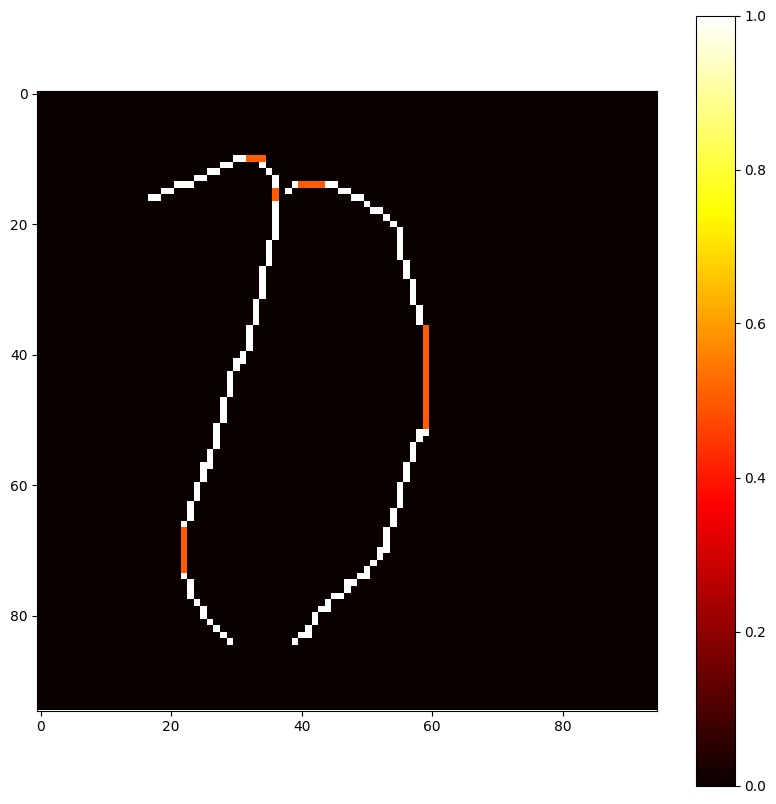

In [79]:
seq_lv_ind = RNG.choice(list(SEQ_LV_IND_TO_META.keys()))
seq_lv_meta = SEQ_LV_IND_TO_META[seq_lv_ind]
engram = ENGRAMS[seq_lv_meta.engram_id]
print(f'seq_lv_ind={seq_lv_ind}, cos_sim_thres={seq_lv_meta.cos_sim_thres:.2f}, engram_id={engram.engram_id}, image_id={engram.image_id}, value={engram.value}')
render_w_vec_heatmap(seq_lv_meta)

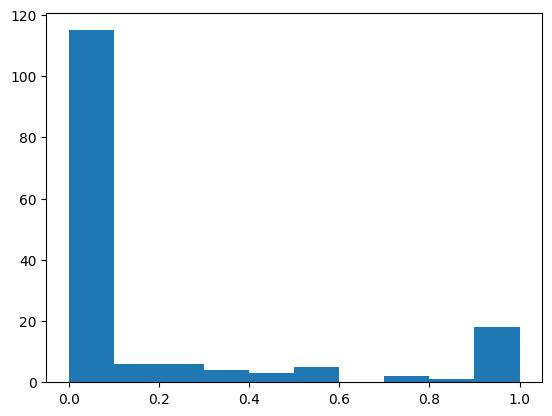

In [69]:
cos_sim_thres_list = list(map(lambda seq_lv_meta: seq_lv_meta.cos_sim_thres, SEQ_LV_IND_TO_META.values()))
neg_pos = list(map(lambda seq_lv_meta: (seq_lv_meta.neg_matches_count, seq_lv_meta.pos_matches_count), SEQ_LV_IND_TO_META.values()))
neg_pos = np.array(neg_pos)
neg_pos_denom = neg_pos.sum(axis=1)
s = neg_pos[:,0] / np.where(neg_pos_denom > 0, neg_pos_denom, 1)
plt.hist(s)
plt.show()

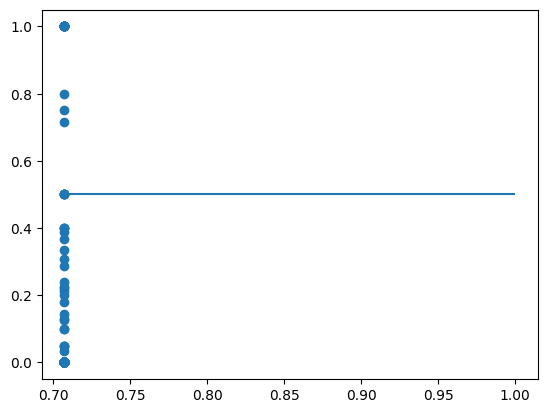

In [70]:
xy = np.array(list(zip(cos_sim_thres_list, s)))
plt.scatter(xy[:,0], xy[:,1])
plt.hlines(0.5, np.min(xy[:,0]), 1)
plt.show()

In [82]:
seq_lv_meta.history

[]

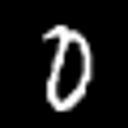

In [81]:
get_raw_image(1600, df_train_images)

In [193]:
df_train_images.loc[54207]

index                                                             1801
value                                                                7
png                  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
outer_si_ind_dict    b'\x80\x04\x95\x079\x00\x00\x00\x00\x00\x00}\x...
inner_si_ind_dict    b'\x80\x04\x95i\x86\x00\x00\x00\x00\x00\x00}\x...
outer_sequences      b'\x80\x04\x95w\x02\x00\x00\x00\x00\x00\x00]\x...
inner_sequences      b'\x80\x04\x95N\x00\x00\x00\x00\x00\x00\x00]\x...
Name: 54207, dtype: object

In [91]:
0.1 * (0.9 ** 4)

0.06561

In [92]:
COS_SIM_45 + 0.034 * 4

np.float64(0.8431067811865476)

In [93]:
1/29

0.034482758620689655

In [106]:
nus = []
updates_counts = []

for seq_lv_ind, seq_lv_meta in SEQ_LV_IND_TO_META.items():
    nus.append(seq_lv_meta.nu)
    updates_counts.append(seq_lv_meta.updates_count)

nus = np.hstack(nus)
updates_counts = np.hstack(updates_counts)
np.histogram(nus), np.histogram(updates_counts)

AttributeError: 'SeqLatentVec' object has no attribute 'updates_count'

In [123]:
list(filter(lambda i_uc: i_uc[1] > 1400, enumerate(updates_counts)))

[(14, np.int64(1479))]

In [125]:
# ENGRAMS[SEQ_LV_IND_TO_META[14].engram_id]

In [75]:
(SEQ_LVS.array_active[3] != 0).sum()

np.int64(553)

In [108]:
seq_lv_ind = 7
w_vec = SEQ_LV_IND_TO_META[seq_lv_ind].w_vec
SEQ_LV_IND_TO_META[seq_lv_ind].updates_count, np.unique_counts(w_vec), w_vec.sum(), np.sqrt(np.sum(w_vec ** 2))

(0,
 UniqueCountsResult(values=array([0., 1.], dtype=float32), counts=array([4056,  444])),
 np.float32(444.0),
 np.float32(21.071308))

In [274]:
seq_lv_updates_history[engram_seq_lv_ind]

[np.int64(7165),
 np.int64(44383),
 np.int64(41772),
 np.int64(8715),
 np.int64(27422),
 np.int64(5857),
 np.int64(27375),
 np.int64(15579),
 np.int64(46153),
 np.int64(2248),
 np.int64(23565),
 np.int64(11484),
 np.int64(30149),
 np.int64(45797),
 np.int64(58604),
 np.int64(4168),
 np.int64(46149),
 np.int64(38608),
 np.int64(53024),
 np.int64(8715),
 np.int64(23565),
 np.int64(30149),
 np.int64(8715),
 np.int64(23565),
 np.int64(30149),
 np.int64(8715),
 np.int64(23565),
 np.int64(30149),
 np.int64(8715)]

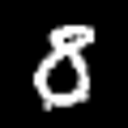

In [162]:
# %%time
image_id = RNG.choice(df_train_images.index)
image_id = 30149
image = Image.open(io.BytesIO(df_train_images.loc[image_id]['png']))
image

In [111]:
cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T

In [45]:
matchee = create_matchee(df_train_images.loc[image_id])

In [57]:
xp_array_from_gpu(cos_sim_mat[i,j])

array(0.52802728)

In [60]:
xp.take(cos_sim_ma, top_mat_indices)

array([0.52802728, 0.52805699, 0.52852144, 0.52870091, 0.5288168 ,
       0.52899192, 0.52904237, 0.52910437, 0.5291858 , 0.52921132,
       0.52932992, 0.52981349, 0.52987864, 0.5298983 , 0.53001637,
       0.53091887, 0.53181364, 0.53184084, 0.53200186, 0.53210089,
       0.53222864, 0.53257177, 0.5333655 , 0.53353145, 0.5341961 ,
       0.53454791, 0.53501479, 0.53565665, 0.53640483, 0.53650111,
       0.53715824, 0.53774765, 0.53831506, 0.53844076, 0.53849261,
       0.53886665, 0.53924699, 0.53941241, 0.53971616, 0.53995301,
       0.54011405, 0.54018985, 0.54027345, 0.54049893, 0.54050326,
       0.54052553, 0.54053141, 0.54081165, 0.54082106, 0.54088954,
       0.54119227, 0.54148538, 0.54150746, 0.54151672, 0.54168996,
       0.54189594, 0.54219426, 0.54231309, 0.54250883, 0.54259895,
       0.54268381, 0.54277117, 0.54289654, 0.54373794, 0.54374626,
       0.54377325, 0.54378835, 0.54380495, 0.54387874, 0.54398342,
       0.54403525, 0.5441069 , 0.5442786 , 0.54442379, 0.54472

In [61]:
a1 = np.arange(9).reshape(3, 3)
a1

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [69]:
a1.ravel()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [71]:
np.flip(a1.ravel())

array([8, 7, 6, 5, 4, 3, 2, 1, 0])

In [68]:
type(top_mat_indices)

numpy.ndarray

In [72]:
%%time
inspect_depth = 100

match_tab_columns = defaultdict(list)
cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
cos_sim_values = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
top_mat_indices = np.flip(top_mat_indices)
cos_sim_values = np.flip(cos_sim_values)

for top_mat_index, cos_sim_value in zip(top_mat_indices, cos_sim_values):
    i = top_mat_index // cos_sim_mat.shape[1]
    j = top_mat_index % cos_sim_mat.shape[1]
    seq_lv_meta = SEQ_LV_IND_TO_META[i]
    engram = ENGRAMS[seq_lv_meta.engram_id]
    match_tab_columns['engram_seq_lv_ind'].append(i)
    match_tab_columns['matchee_seq_lv_ind'].append(j)
    match_tab_columns['cos_sim'].append(cos_sim_value)
    match_tab_columns['engram_id'].append(engram.engram_id)
    match_tab_columns['engram_value'].append(engram.value)
    match_tab_columns['engram_image_id'].append(engram.image_id)  
    match_tab_columns['engram_phase'].append(seq_lv_meta.phase)
    match_tab_columns['engram_seq_lv_code'].append(seq_lv_meta.seq_lv_code)
    match_tab_columns['matchee_seq_lv_code'].append(matchee.seq_lv_codes[j])

df_match_tab = pd.DataFrame(match_tab_columns)
df_match_tab.head(10)

CPU times: user 8.3 ms, sys: 13.1 ms, total: 21.4 ms
Wall time: 19.4 ms


,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code
0,33,813,0.560668,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 1))"
1,33,812,0.559649,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 0))"
2,33,815,0.555197,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 1), (3, 1))"
3,33,814,0.554326,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 1), (3, 0))"
4,37,2614,0.552823,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((3, 1), (1, 0), (2, 1), (4, 1), (0, 0))"
5,37,2612,0.552823,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((3, 1), (1, 0), (2, 1), (4, 0), (0, 0))"
6,33,3149,0.552264,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((4, 0), (0, 1), (2, 1), (1, 0), (3, 1))"
7,33,3148,0.550657,1,4,26704,0,"((2, 0), (0, 0), (1, 1))","((4, 0), (0, 1), (2, 1), (1, 0), (3, 0))"
8,37,813,0.550207,1,4,26704,0,"((2, 1), (0, 0), (1, 1))","((1, 0), (0, 1), (2, 1), (4, 0), (3, 1))"
9,2,1005,0.550045,1,4,26704,0,"((0, 0), (1, 1), (2, 0))","((1, 0), (2, 1), (0, 1), (4, 0), (3, 1))"


# Test

In [242]:
count = 200
get_test_image_ids = lambda df: RNG.choice(df.index.unique(), min(count, len(df)), replace=False)
TestRunSource = namedtuple('TestRunSource', ['df_images', 'db_con', 'source_ds', 'test_image_ids'])
test_run_source = {
    'test': TestRunSource(df_test_images, test_db_con, 'test', get_test_image_ids(df_test_images)),
    'train': TestRunSource(df_train_images, train_db_con, 'train', get_test_image_ids(df_train_images)),
    'train2': TestRunSource(df_train_images, train_db_con, 'train2', train_image_ids)
}['test']

In [243]:
%%time
test_results_db_con.cursor().execute('INSERT INTO test_runs(dummy) VALUES(1)')
test_results_db_con.commit()
test_run_id = test_results_db_con.cursor().execute('SELECT MAX(test_run_id) FROM test_runs').fetchone()[0]
test_result_rows = defaultdict(list)
match_tabs_raw = []
match_tabs = []

for image_id in tqdm(test_run_source.test_image_ids):
    df_image = test_run_source.df_images.loc[image_id]
    image_value = df_image['value']
    matchee = create_matchee_cached(df_image)
    
    df_match_tab_raw = get_match_tab(matchee) #, inspect_depth=1000)
    df_match_tab_raw['test_image_id'] = image_id
    df_match_tab_raw['true_value'] = image_value
    match_tabs_raw.append(df_match_tab_raw)
    
    df_match_tab = df_match_tab_raw[df_match_tab_raw['is_match'] == True] if len(df_match_tab_raw) > 0 else df_match_tab_raw
    match_tabs.append(df_match_tab)
    
    infer_value, engram_image_id, cos_sim = ('', -1, 0)
        
    if len(df_match_tab) > 0:
        infer_value, engram_image_id, cos_sim = df_match_tab.iloc[0][['engram_value', 'engram_image_id', 'cos_sim']]
    
    test_result_rows['test_run_id'].append(test_run_id)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(f'[{','.join([])}]')
    test_result_rows['train_images_count'].append(TRAIN_IMAGES_COUNT)
    test_result_rows['train_runs_count'].append(TRAIN_RUNS_COUNT)
    test_result_rows['source_ds'].append(test_run_source.source_ds)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['engram_image_id'].append(engram_image_id)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['cos_sim'].append(cos_sim)
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    test_result_rows['engrams_count'].append(len(ENGRAMS))

df_test_results_for_run = pd.DataFrame(test_result_rows)
df_test_results_for_run['timestamp'] = datetime.datetime.now()

if DBUtils.is_table_exists(test_results_db_con, 'test_results'):
    DBUtils.ensure_table_columns(test_results_db_con, 'test_results', list(df_test_results_for_run.columns))
    
df_test_results_for_run.to_sql(name='test_results', con=test_results_db_con, if_exists='append')
pd.DataFrame({'test_run_id': [test_run_id], 'match_tabs': [pickle.dumps(match_tabs)]}).to_sql(name='test_run_artifacts', con=test_results_db_con, if_exists='append');

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 37.4 s, sys: 565 ms, total: 38 s
Wall time: 6.6 s


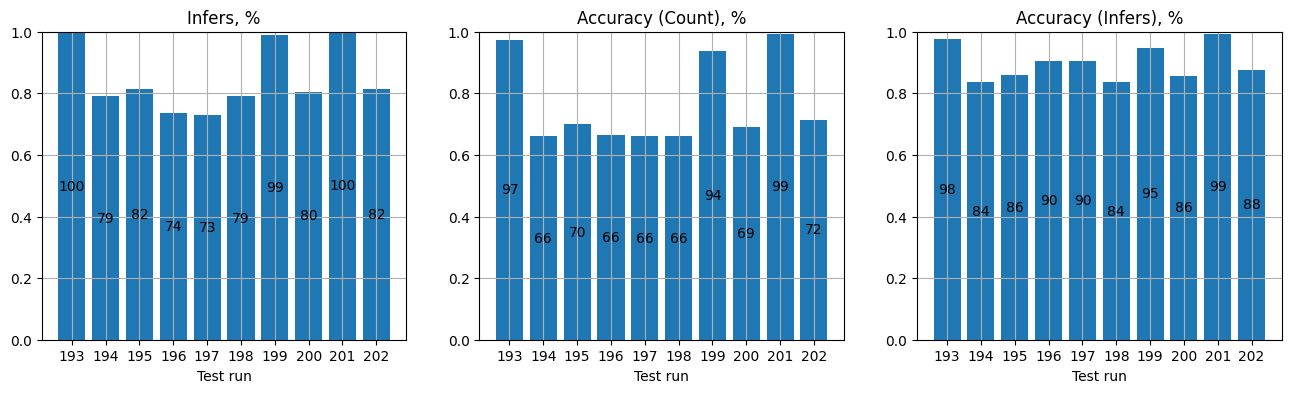

,timestamp,source_ds,train_images_count,engrams_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,
193,2025-05-26 13:58:10.413003,train2,729,173,500,498,487,0.996,0.974,0.977912
194,2025-05-26 13:58:30.952440,test,729,173,200,158,132,0.790,0.660,0.835443
195,2025-05-26 14:00:05.445578,test,633,170,200,163,140,0.815,0.700,0.858896
196,2025-05-26 14:03:41.462337,test,575,194,200,147,133,0.735,0.665,0.904762
197,2025-05-26 14:04:36.219424,test,598,199,200,146,132,0.730,0.660,0.904110
198,2025-05-26 14:06:02.170398,test,729,173,200,158,132,0.790,0.660,0.835443
199,2025-05-26 14:10:40.659687,train2,5000,209,500,495,469,0.990,0.938,0.947475
200,2025-05-26 14:11:07.627946,test,5000,209,200,161,138,0.805,0.690,0.857143
201,2025-05-26 14:16:06.499830,train2,2669,213,500,500,497,1.000,0.994,0.994000


In [244]:
df_test_results2 = pd.read_sql_query('''
SELECT * FROM test_results 
WHERE test_run_id IN (SELECT test_run_id FROM test_runs ORDER BY test_run_id DESC LIMIT 10) 
ORDER BY test_run_id ASC
''', con=test_results_db_con)
df_test_results2['test_run_id'] = df_test_results2['test_run_id'].astype(int)
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'timestamp': 'first',
                                                                     'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'engrams_count': 'first',
                                                                     'train_runs_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.sort_values(by=['test_run_id'], inplace=True)
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2[['timestamp', 'source_ds', 'train_images_count', 'engrams_count', 'count', 'infers', 'correct_infers', 'infer_ratio', 'accuracy_count', 'accuracy_infers']]

## analyze

In [114]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index']]
df_incorrect.head(10)

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index
3,51119,40216,2,7,0.823126,3
8,18149,-1,6,,0.000000,8
10,32636,-1,8,,0.000000,10
20,9600,-1,2,,0.000000,20
21,37307,-1,2,,0.000000,21
22,3397,-1,3,,0.000000,22
24,31620,-1,6,,0.000000,24
35,38494,-1,0,,0.000000,35
43,15883,-1,0,,0.000000,43
44,22962,-1,6,,0.000000,44


In [171]:
# df_correct = df_test_results_for_run.loc[df_test_results_for_run.true_value == df_test_results_for_run.infer_value].copy()
# df_correct = df_correct[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index']]
# df_correct.head(10)

In [115]:
match_tab_index = 3
match_tab = match_tabs_raw[match_tab_index]
# match_tab = match_tabs[match_tab_index]
column_names = ['test_image_id', 'true_value', 'engram_value', 'cos_sim', 'cos_sim_thres', 'is_match',
                'engram_id', 'engram_image_id', 'engram_seq_reading', 'engram_seq_lv_ind',
                'matchee_seq_reading', 'matchee_seq_lv_ind']
match_tab.head(10)[column_names]

,test_image_id,true_value,engram_value,cos_sim,cos_sim_thres,is_match,engram_id,engram_image_id,engram_seq_reading,engram_seq_lv_ind,matchee_seq_reading,matchee_seq_lv_ind
0,51119,2,7,0.823126,0.796604,True,1091,40216,"((0, 0), (1, 0))",16,"((1, 1), (0, 0))",6
1,51119,2,2,0.795236,0.793449,True,939,42373,"((0, 0), (1, 0))",14,"((1, 1), (0, 0))",6
2,51119,2,2,0.762130,0.714774,True,950,52118,"((0, 0), (1, 0))",25,"((1, 1), (0, 0))",6
3,51119,2,7,0.718115,0.749510,False,934,50278,"((0, 0),)",9,"((1, 0), (0, 0))",4
4,51119,2,7,0.664381,0.809533,False,957,52181,"((0, 0), (1, 0), (2, 0))",32,"((0, 0), (1, 1))",1
5,51119,2,7,0.653490,0.749510,False,934,50278,"((0, 0),)",9,"((1, 0), (0, 1))",5
6,51119,2,7,0.633185,0.809533,False,957,52181,"((0, 0), (1, 0), (2, 0))",32,"((1, 1), (0, 0))",6
7,51119,2,0,0.630794,0.827758,False,1073,30149,"((0, 0), (1, 0))",148,"((1, 1), (0, 0))",6
8,51119,2,2,0.628200,0.762454,False,1031,35235,"((0, 0), (1, 0))",106,"((0, 0), (1, 1))",1
9,51119,2,6,0.627848,0.854428,False,1093,48471,"((0, 0), (1, 0))",19,"((1, 1), (0, 0))",6


In [116]:
# get_raw_image(41464, df_train_images)

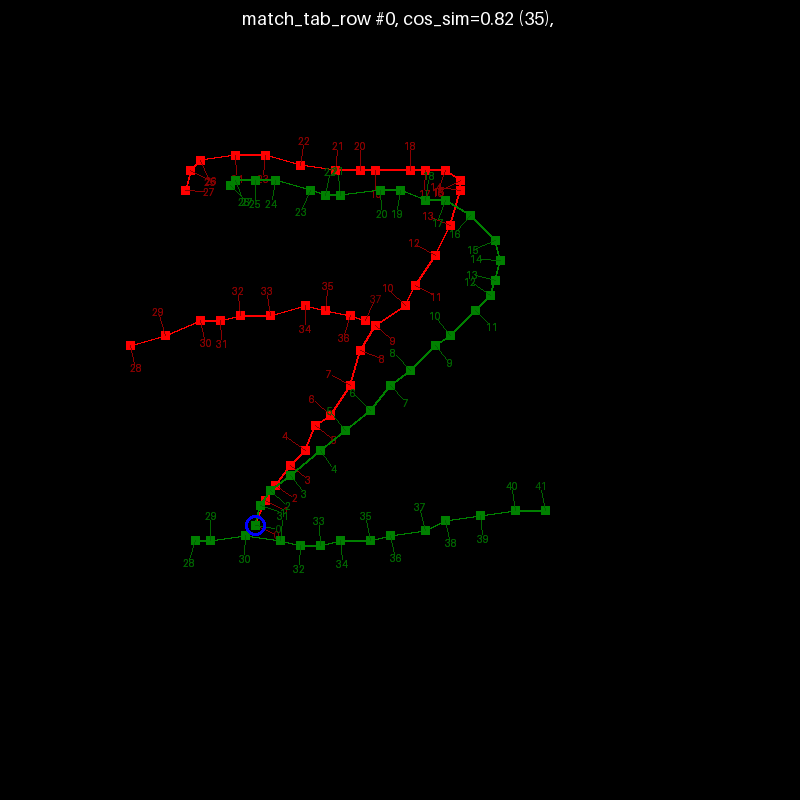

In [117]:
df_match_tab_row = match_tab.iloc[0]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_reading'])
# matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv_meta = SEQ_LV_IND_TO_META[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv_orig = df_match_tab_row['engram_seq_lv_orig']

matchee_seq_reading = df_match_tab_row['matchee_seq_reading']
matchee_seq_lv_ind = matchee.seq_readings.index(matchee_seq_reading)
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv_orig = matchee.seq_lvs_orig[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy = np.array([10, 10]), k=5)

In [80]:
(engram_seq_lv_orig @ matchee_seq_lv_orig) / (np.linalg.norm(engram_seq_lv_orig) * np.linalg.norm(matchee_seq_lv_orig))

np.float32(0.8304997)

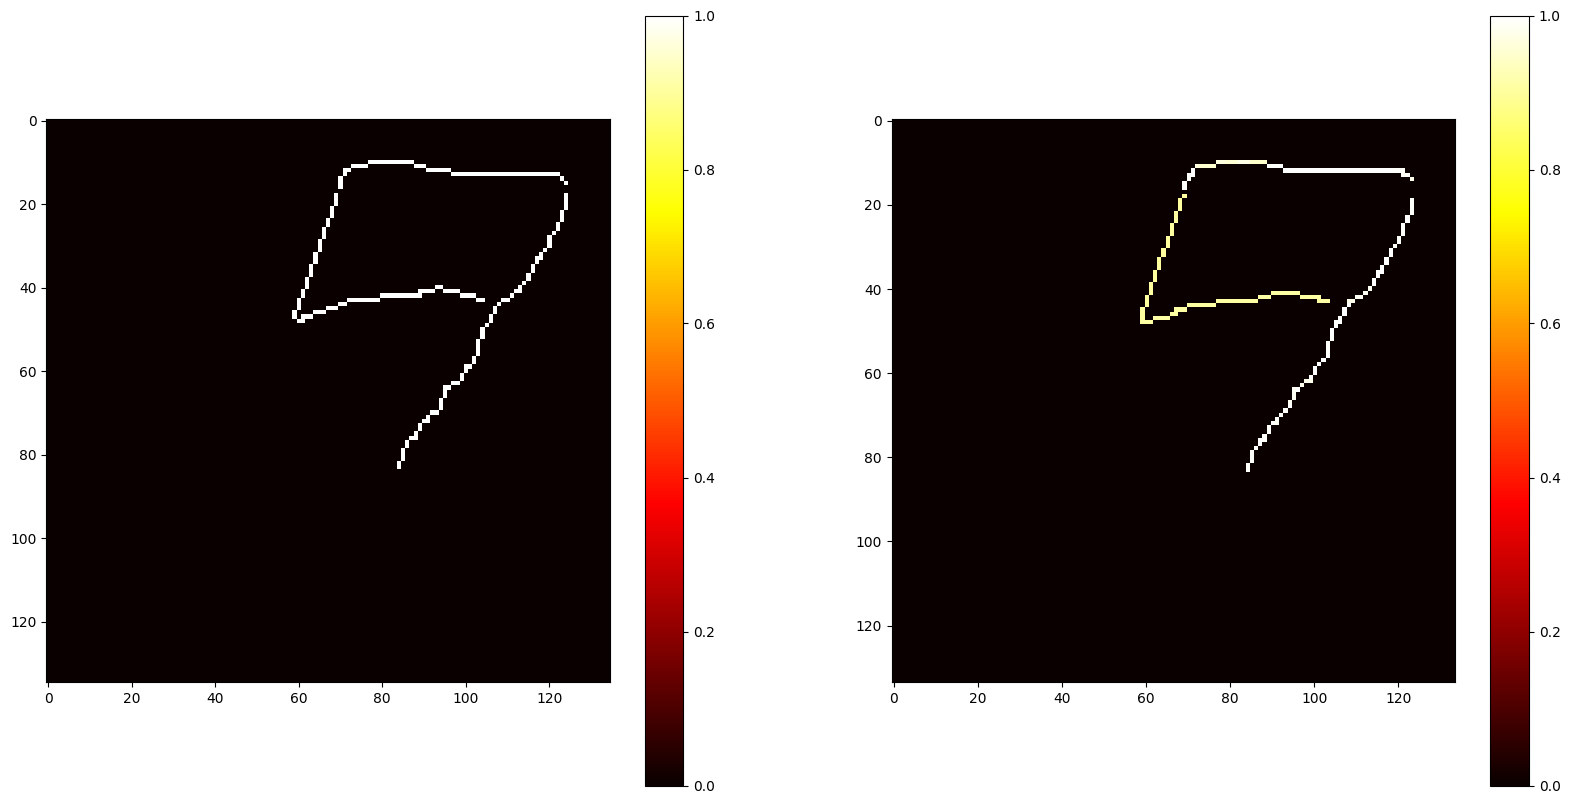

In [118]:
render_seq_lv_orig_upd(engram_seq_lv_meta)

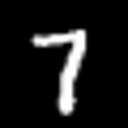

In [93]:
get_raw_image(57196, df_train_images)

In [82]:
engram_seq_lv_meta.cos_sim_thres

0.7133076202869415

In [81]:
engram_seq_lv_meta.seq_lv_ind

84

In [94]:
ENGRAMS[engram_seq_lv_meta.engram_id].image_id

168

In [133]:
engram_seq_lv_meta.pos_matches_count

1

In [120]:
engram_seq_lv_meta.history

{50923: SeqLatentVecHistoryItem(image_id=np.int64(50923), cos_sim=0.7722010612487793, is_correct_match=True),
 np.int64(683): SeqLatentVecHistoryItem(image_id=np.int64(683), cos_sim=0.7362493276596069, is_correct_match=True),
 np.int64(59140): SeqLatentVecHistoryItem(image_id=np.int64(59140), cos_sim=0.7473859190940857, is_correct_match=True),
 np.int64(43408): SeqLatentVecHistoryItem(image_id=np.int64(43408), cos_sim=0.7221878170967102, is_correct_match=True),
 np.int64(24425): SeqLatentVecHistoryItem(image_id=np.int64(24425), cos_sim=0.7845925092697144, is_correct_match=False),
 np.int64(56451): SeqLatentVecHistoryItem(image_id=np.int64(56451), cos_sim=0.7184270620346069, is_correct_match=True),
 np.int64(44500): SeqLatentVecHistoryItem(image_id=np.int64(44500), cos_sim=0.7165065407752991, is_correct_match=True),
 np.int64(56795): SeqLatentVecHistoryItem(image_id=np.int64(56795), cos_sim=0.7697305679321289, is_correct_match=False),
 np.int64(3304): SeqLatentVecHistoryItem(image_id=np

In [143]:
np.histogram(get_w_vec(engram_seq_lv_meta))

(array([4072,    0,   58,  136,   23,   33,   29,   56,   70,   23]),
 array([0.        , 0.1       , 0.2       , 0.3       , 0.4       ,
        0.5       , 0.6       , 0.7       , 0.8       , 0.90000004,
        1.        ], dtype=float32))

In [156]:
sublv_indices = slice(1, 2)
indices2 = slice(0, 150)
# indices2 = slice(150, -1)
# indices2 = slice(0, -1)
engram_seq_sublv = engram_seq_lv_orig.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2]
matchee_seq_sublv = matchee_seq_lv_orig.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2]
(engram_seq_sublv @ matchee_seq_sublv) / (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))

np.float32(0.6617729)

In [157]:
engram_seq_sublv

array([-0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394, -0.33333334,  0.93939394, -0.33333334,  0.93939394,
       -0.33333334,  0.93939394, -0.33333334,  0.93939394, -0.33333334,
        0.93939394,  0.        ,  0.        ,  0.        ,  0.  

In [164]:
engram_seq_sublv = engram_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2] 
matchee_seq_sublv = matchee_seq_lv.reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()[indices2]
(engram_seq_sublv @ matchee_seq_sublv) / (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))

np.float32(0.66177285)

In [165]:
engram_seq_sublv

array([-0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646,
       -0.0211152 ,  0.05950646, -0.0211152 ,  0.05950646, -0.0211152 ,
        0.05950646,  0.        ,  0.        ,  0.        ,  0.  

In [254]:
engram_seq_sublv = (engram_seq_lv_orig * engram_seq_lv_meta.w_vec).reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()
# matchee_seq_sublv = (matchee_seq_lv_orig * engram_seq_lv_meta.w_vec).reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()
matchee_seq_sublv = (matchee_seq_lv_orig).reshape(SEQ_SUBLVS_COUNT, -1)[sublv_indices].ravel()
(engram_seq_sublv @ matchee_seq_sublv) / (np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv))

np.float32(0.7419082)

In [249]:
np.linalg.norm(engram_seq_sublv), \
np.linalg.norm(matchee_seq_sublv), \
engram_seq_sublv @ matchee_seq_sublv, \
np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv), \
(engram_seq_sublv != 0).sum(), (matchee_seq_sublv != 0).sum(), 

(np.float32(11.113664),
 np.float32(14.933185),
 np.float32(142.9913),
 np.float32(165.96239),
 np.int64(401),
 np.int64(421))

In [255]:
np.linalg.norm(engram_seq_sublv), \
np.linalg.norm(matchee_seq_sublv), \
engram_seq_sublv @ matchee_seq_sublv, \
np.linalg.norm(engram_seq_sublv) * np.linalg.norm(matchee_seq_sublv), \
(engram_seq_sublv != 0).sum(), (matchee_seq_sublv != 0).sum(), 

(np.float32(11.523941),
 np.float32(14.933185),
 np.float32(127.67435),
 np.float32(172.08914),
 np.int64(376),
 np.int64(421))

In [ ]:
np.histogram(engram_seq_lv_meta.w_vec)

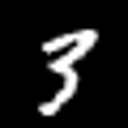

In [213]:
Image.open(io.BytesIO(df_test_images.loc[100003769]['png']))

In [175]:
list(map(lambda kv: kv[1].image_id, filter(lambda kv: kv[1].value == '6', ENGRAMS.items())))

[25959, 46074, 39577, 27536, 39777, 5654]

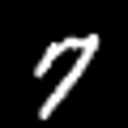

In [212]:
Image.open(io.BytesIO(df_train_images.loc[53171]['png']))

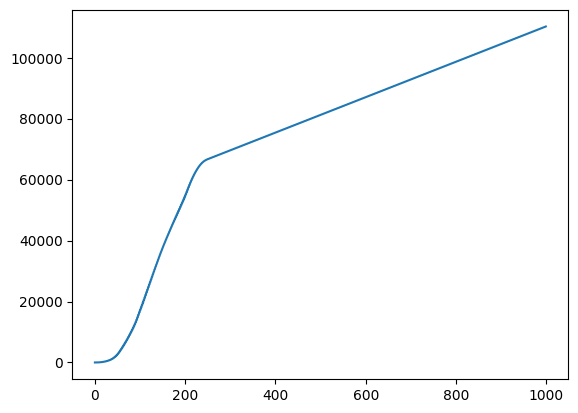

In [128]:
seq_lvs_diff = 0
seq_lvs_diff_cums = []

for vec1, vec2 in zip(engram_seq_lv[:1000], matchee_seq_lv[:1000]):
    vec = vec1 - vec2
    vec = vec ** 2
    seq_lvs_diff += vec.sum()
    seq_lvs_diff_cums.append(seq_lvs_diff)

seq_lvs_diff

plt.plot(seq_lvs_diff_cums)
plt.show()

In [130]:
matchee = create_matchee(df_test_image)
mt = get_match_tab(matchee, inspect_depth=9999999)
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((1,0), (2,0), (3,0), (0,0)))]
# mt[(mt['engram_image_id'] == 39577) & (mt['matchee_seq_lv_code'] == ((0,0), (1,0)))]
# mt[(mt['matchee_seq_lv_code'] == ((1,0), (0,0)))]
mt[(mt['engram_image_id'] == 5654)]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,diff_sq,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code
3718,14157,4,-1,1.065956e+06,46,6,5654,0,"((0, 1), (1, 1))","((1, 0), (0, 0))"
3719,14161,0,-1,1.065956e+06,46,6,5654,0,"((1, 1), (0, 1))","((0, 0), (1, 0))"
3720,14155,6,-1,1.080466e+06,46,6,5654,0,"((0, 0), (1, 1))","((1, 1), (0, 0))"
3721,14160,1,-1,1.080466e+06,46,6,5654,0,"((1, 1), (0, 0))","((0, 0), (1, 1))"
3792,14157,6,-1,1.134638e+06,46,6,5654,0,"((0, 1), (1, 1))","((1, 1), (0, 0))"
...,...,...,...,...,...,...,...,...,...,...
116653,14158,1,-1,7.748395e+06,46,6,5654,0,"((1, 0), (0, 0))","((0, 0), (1, 1))"
116706,14156,6,-1,7.807281e+06,46,6,5654,0,"((0, 1), (1, 0))","((1, 1), (0, 0))"
116707,14159,1,-1,7.807281e+06,46,6,5654,0,"((1, 0), (0, 1))","((0, 0), (1, 1))"
116709,14154,4,-1,7.808612e+06,46,6,5654,0,"((0, 0), (1, 0))","((1, 0), (0, 0))"


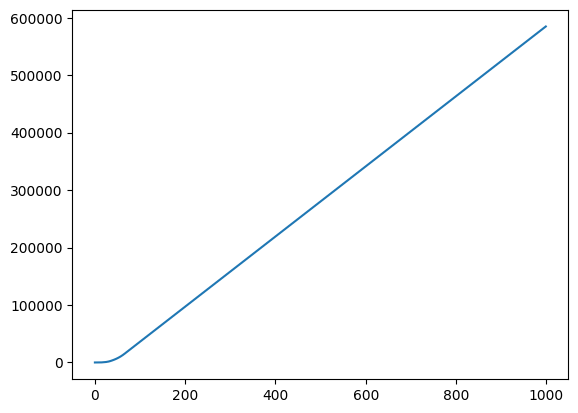

In [131]:
df_match_tab_row = mt.iloc[3718]
engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]

seq_lvs_diff = 0
seq_lvs_diff_cums = []

for vec1, vec2 in zip(engram_seq_lv[:1000], matchee_seq_lv[:1000]):
    vec = vec1 - vec2
    vec = vec ** 2
    seq_lvs_diff += vec.sum()
    seq_lvs_diff_cums.append(seq_lvs_diff)

seq_lvs_diff

plt.plot(seq_lvs_diff_cums)
plt.show()

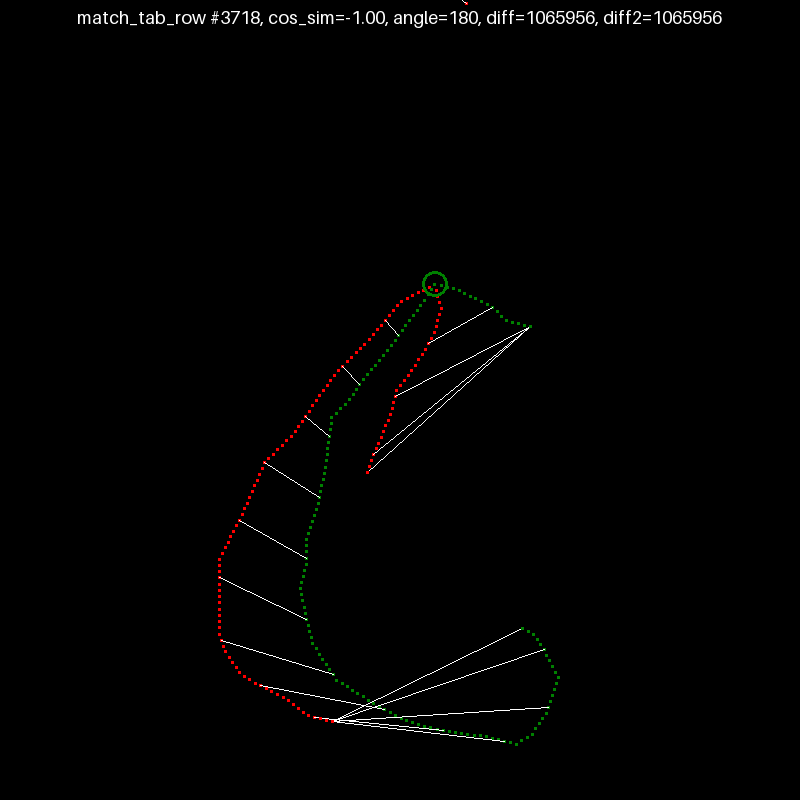

In [132]:
render_match_tab_row(mt.iloc[3718], matchee, use_seq_lv=True) # 1324

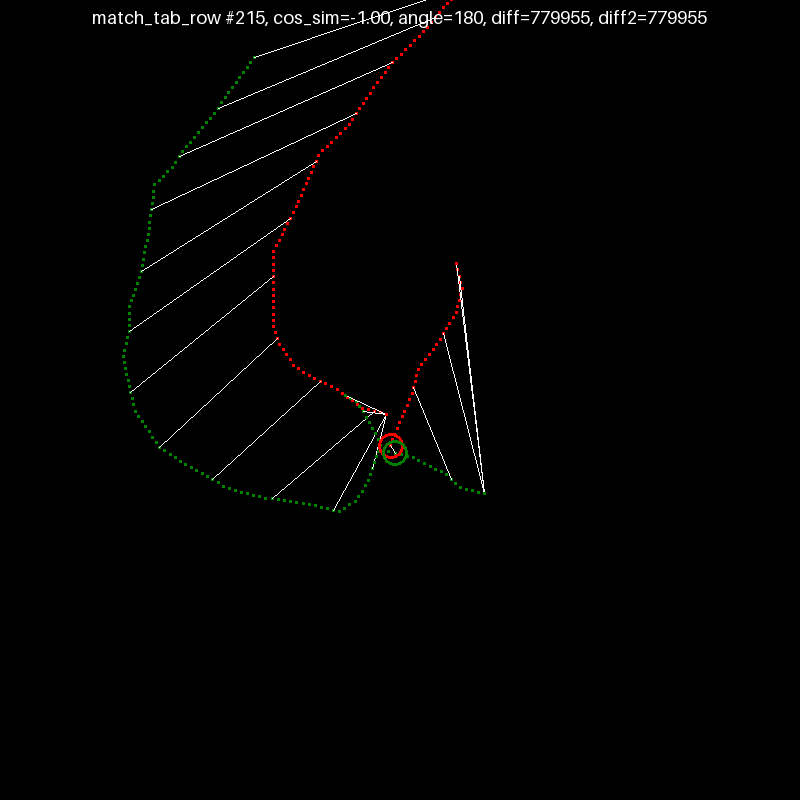

In [306]:
render_match_tab_row(mt.iloc[215], matchee, use_seq_lv=True) # 1324

## xxx

In [203]:
# df_test_results_for_run_c = df_test_results_for_run.copy()

In [204]:
test_run_id_c = int(df_test_results_for_run_c['test_run_id'][0])
match_tabs_c = pickle.loads(pd.read_sql(f'SELECT match_tabs FROM test_run_artifacts WHERE test_run_id = {test_run_id_c}', con=test_results_db_con).iloc[0]['match_tabs'])

In [206]:
df_incorrect_c = df_test_results_for_run_c.loc[df_test_results_for_run_c.true_value != df_test_results_for_run_c.infer_value]
df_incorrect_c = df_incorrect_c[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_correct_c = df_test_results_for_run_c.loc[df_test_results_for_run_c.true_value == df_test_results_for_run_c.infer_value].copy()
df_correct_c = df_correct_c[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_incorrect_c.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
0,100003752,29437,4,6,0.841084,0,cos_sim
1,100001264,9758,4,9,0.893869,1,cos_sim
7,100009710,44106,6,5,0.807008,7,cos_sim
21,100001178,1033,4,2,0.788638,21,cos_sim
38,100001012,9484,7,2,0.821328,38,cos_sim


In [207]:
df_correct_c.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
2,100005629,38800,2,2,0.776715,2,cos_sim
3,100007696,56698,4,4,0.876949,3,cos_sim
4,100000111,43598,7,7,0.907990,4,cos_sim
5,100001435,42773,9,9,0.756153,5,cos_sim
6,100007232,15507,1,1,0.875834,6,cos_sim


In [257]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'engram_image_id', 'true_value', 'infer_value', 'cos_sim', 'match_tab_index', 'match_tab_method']]
df_incorrect.head()

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
8,100007903,3924,7,2,0.773791,8,cos_sim
12,100004207,29437,8,6,0.734214,12,cos_sim
18,100008928,6448,9,4,0.733242,18,cos_sim
20,100007613,42349,6,0,0.774789,20,cos_sim
37,100001012,57752,7,2,0.768041,37,cos_sim


In [258]:
set(df_incorrect['test_image_id']) - set(df_incorrect_c['test_image_id'])#, set(df_incorrect_c['test_image_id']) - set(df_incorrect['test_image_id'])

{100000900,
 100001017,
 100001099,
 100003279,
 100003728,
 100004015,
 100006248,
 100006294,
 100006833,
 100006850,
 100006972,
 100007613,
 100007747,
 100008495}

In [259]:
df_incorrect[df_incorrect['test_image_id'] == 100000900]

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
63,100000900,50564,1,4,0.835808,63,cos_sim


In [260]:
df_correct_c[df_correct_c['test_image_id'] == 100000900]

,test_image_id,engram_image_id,true_value,infer_value,cos_sim,match_tab_index,match_tab_method
145,100000900,15730,1,1,0.857304,145,cos_sim


In [218]:
# list(filter(lambda kv: kv[1].image_id == 15730,  ENGRAMS.items()))

In [261]:
mt = match_tabs[63]
mt[mt['engram_image_id'] == 15730]
# mt

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
2,2418,24,0.820190,3086,1,15730,0,"((1, 0), (2, 0), (0, 0))","((1, 0), (2, 0), (0, 0))",100000900,1
3,2417,16,0.795339,3086,1,15730,0,"((1, 0), (0, 0), (2, 0))","((1, 0), (0, 0), (2, 0))",100000900,1
4,2415,0,0.783616,3086,1,15730,0,"((0, 0), (1, 0), (2, 0))","((0, 0), (1, 0), (2, 0))",100000900,1
5,2420,40,0.781336,3086,1,15730,0,"((2, 0), (1, 0), (0, 0))","((2, 0), (1, 0), (0, 0))",100000900,1
7,2419,32,0.764612,3086,1,15730,0,"((2, 0), (0, 0), (1, 0))","((2, 0), (0, 0), (1, 0))",100000900,1
46,2420,24,0.697691,3086,1,15730,0,"((2, 0), (1, 0), (0, 0))","((1, 0), (2, 0), (0, 0))",100000900,1
48,2417,32,0.696572,3086,1,15730,0,"((1, 0), (0, 0), (2, 0))","((2, 0), (0, 0), (1, 0))",100000900,1
58,2419,16,0.684397,3086,1,15730,0,"((2, 0), (0, 0), (1, 0))","((1, 0), (0, 0), (2, 0))",100000900,1
76,2416,8,0.676281,3086,1,15730,0,"((0, 0), (2, 0), (1, 0))","((0, 0), (2, 0), (1, 0))",100000900,1
99,2416,0,0.659447,3086,1,15730,0,"((0, 0), (2, 0), (1, 0))","((0, 0), (1, 0), (2, 0))",100000900,1


In [262]:
match_tabs_c[145]

,engram_seq_lv_ind,matchee_seq_lv_ind,cos_sim,engram_id,engram_value,engram_image_id,engram_phase,engram_seq_lv_code,matchee_seq_lv_code,test_image_id,true_value
0,56975,33,0.857304,2577,1,15730,0,"((2, 0), (0, 0), (1, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
1,56977,35,0.845943,2577,1,15730,0,"((2, 0), (0, 1), (1, 1))","((2, 0), (0, 1), (1, 1))",100000900,1
2,56957,15,0.844402,2577,1,15730,0,"((0, 1), (2, 1), (1, 1))","((0, 1), (2, 1), (1, 1))",100000900,1
3,56961,19,0.837876,2577,1,15730,0,"((1, 0), (0, 1), (2, 1))","((1, 0), (0, 1), (2, 1))",100000900,1
4,56532,0,0.835808,2572,4,50564,0,"((2, 0), (1, 0), (0, 0))","((0, 0), (1, 0), (2, 0))",100000900,1
...,...,...,...,...,...,...,...,...,...,...,...
95,29075,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (4, 0), (2, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
96,29045,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (2, 1), (4, 1))","((2, 0), (0, 0), (1, 1))",100000900,1
97,29044,33,0.743445,2526,2,24035,0,"((0, 0), (3, 0), (1, 1), (2, 1), (4, 0))","((2, 0), (0, 0), (1, 1))",100000900,1
98,28627,7,0.743371,2524,1,57931,0,"((1, 1), (0, 1), (2, 1))","((0, 1), (1, 1), (2, 1))",100000900,1


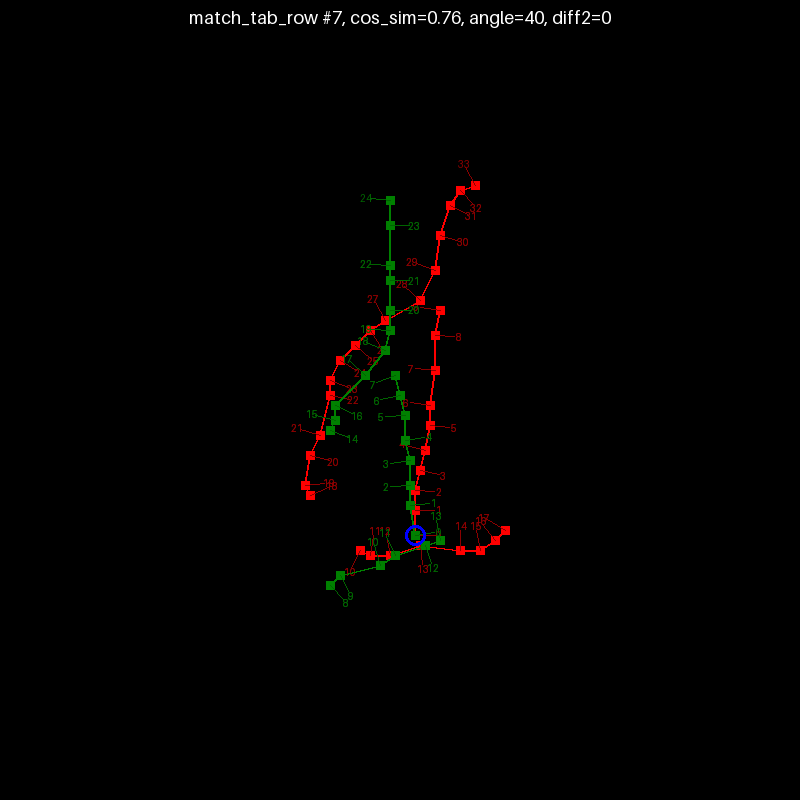

In [264]:
match_tab = match_tabs[63]
df_match_tab_row = match_tab.iloc[7]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = df_test_images.loc[test_image_id]
else:
    df_test_image = df_train_images.loc[test_image_id]

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_lv_code'])
# matchee = create_matchee(df_test_image)

engram_seq_lv_ind = df_match_tab_row['engram_seq_lv_ind']
# engram_seq_lv = SEQ_LVS_COS_SIM.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv = SEQ_LVS.array_active[df_match_tab_row['engram_seq_lv_ind']]
engram_seq_lv2 = SEQ_LVS2.array_active[df_match_tab_row['engram_seq_lv_ind']]

matchee_seq_lv_code = df_match_tab_row['matchee_seq_lv_code']
matchee_seq_lv_ind = matchee.seq_lv_codes.index(matchee_seq_lv_code)
# matchee_seq_lv = matchee.seq_lvs_cos_sim[matchee_seq_lv_ind]
matchee_seq_lv = matchee.seq_lvs[matchee_seq_lv_ind]
matchee_seq_lv2 = matchee.seq_lvs2[matchee_seq_lv_ind]

render_match_tab_row(df_match_tab_row, matchee, use_seq_lv=False, delta_xy = np.array([10, 15]), k=5)

In [246]:
seq_sublv_i = 0
engram_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)].ravel() @ matchee_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)].ravel()

np.float32(30.74998)

In [251]:
engram_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)][100:]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [245]:
matchee_seq_lv2.reshape(-1, 2)[SEQ_SUBLV_LEN*seq_sublv_i:SEQ_SUBLV_LEN*(seq_sublv_i+1)][:50]

array([[-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,  0.95454544],
       [-0.29545453,